In [1]:
%matplotlib nbagg 

In [2]:
# import all plotting packages
import matplotlib.pyplot as plt
from matplotlib import colors, cm, animation
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from lmfit.lineshapes import lorentzian, skewed_voigt, tiny, voigt

In [3]:
# importing system packages
import os
import sys
import time
import itertools
import shutil

# importing the workhorse
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# for reading spec files
import PyMca5.PyMcaCore.SpecFileDataSource as SpecFileDataSource

# for the fitting procedures
from lmfit import *

In [4]:
# In PyMca, the scans are labeled as '15.1' instead of '15'.
def ID_to_str(ID):
    try:
        ID = int(ID)
        return str(ID)+'.1'
    except ValueError:
        print("Error: Invalid scan ID format.")
        return 'nan'

# get spec file.
class specFile():
    def __init__(self, name, path=''):
        if path=='':
            path = os.getcwd()
        else:
            path = path
        filePath = os.path.abspath(os.path.join(path, name))
        
        specFile = SpecFileDataSource.SpecFileDataSource(filePath)
        
        list_scanID_txt = specFile.getSourceInfo()['KeyList']
        list_scanLen = specFile.getSourceInfo()['NumPts']
        list_scanID = []
        for txt in list_scanID_txt:
            num = int(txt[:-2])
            list_scanID.append(num)
            
        self.path = filePath
        self.spec = specFile
        self.scanList = list_scanID
        self.scanLen = list_scanLen
        return


def get_specScan(sf, ID):
    str_ID = ID_to_str(ID)
    scan = sf.spec.getDataObject(str_ID)
    scanKeys = scan.getInfo()['LabelNames']
    scanData = scan.getData()
    scanData = pd.DataFrame(scanData, columns=scanKeys)
    return scanData

# Pulling data out:
# 1) type(get_scan(sf, ID)['E']) is pandas.core.series.Series
# 2) Convert to np.ndarray
# 2.1) a = np.array(get_scan(sf, ID)['E']): will return an 1D ndarray
# 2.2) a = np.ndarray(get_scan(sf, ID)['E']): will generate
# ValueError: sequence too large; cannot be greater than 32

In [5]:
def bin_rixs(rixsf, idList, plotop=True):
    '''
    Combine rixs file
    '''
    for i, k in enumerate(idList):
        df = get_specScan(rixsf, k)
        tempe = np.array(df['E'])
        tempc = np.array(df['C'])
        tempm = np.array(df['M'])
        if i:
            cdata = cdata+tempc
            mdata = mdata+tempm
        else:
            edata = tempe
            cdata = tempc
            mdata = tempm
    
    # Convert to eV and energy loss
    edata = edata*(1.e3)
    ydata = cdata/mdata
    errdata = np.sqrt(cdata)/mdata
    
    #Find the center of elastic peak
    #def max(arr):
    #max_ = arr[0]
    #for item in arr:
    #    if item > max_:
    #        max_ = item
    #return max_ 
        
    
    #Set the center of elastic peak of 0
    
    # Plot data
    if(plotop):
        plt.figure()
        plt.clf()
        plt.errorbar(edata, ydata, yerr=errdata)
    
    return edata, ydata, errdata

In [6]:
def gaussian(params, x, y):
    '''
    1-d gaussian: gaussian(x, area, cen, fwhm, bg)
    '''
    area = params['area']
    cen = params['cen']
    fwhm = params['fwhm']
    bg = params['bg']
    
    sig = fwhm/(2*np.sqrt(2*np.log(2)))
    model = (area/(np.sqrt(2*np.pi)*sig))*np.exp(-(x-cen)**2 /(2*sig**2))+bg
    return model-y

def fit_elastic(x, y, el_pk, el_range, plot_fit=False, print_fit=False):
    '''
    el_pk: Initial guess of the elastic line
    el_wid: Initial guess of the elastic peak width (FWHM)
    '''
    # create a set of Parameters
    params = Parameters()
    #params.add('offset', value=1.)
    params.add('area', value=3e-5)
    params.add('cen', value=el_pk)
    params.add('fwhm', value=0.035, min=1.0e-3)
    params.add('bg', value=0., min=0.)

    # do fit, here with leastsq model
    subx = x[np.where((x>el_pk-el_range) & (x<el_pk+el_range))]
    suby = y[np.where((x>el_pk-el_range) & (x<el_pk+el_range))]
    
    minner = Minimizer(gaussian, params, fcn_args=(subx, suby))
    result = minner.minimize()

    # calculate final result
    final = suby + result.residual

    # write error report
    if print_fit:
        report_fit(result)

    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            plt.plot(subx, suby, 'ko')
            plt.plot(subx, final, 'r-')
            plt.show()
    except ImportError:
        pass
    
    return final, result


# Load data - Tdep

In [7]:
sf = specFile('path_to_spm3_file')

t_pts=17 #number of T points taken
col=3*t_pts #number of cols for data matrix

warmingdata = np.zeros((col, 81))

scan_num = [432, 437, 443, 451, 456, 463, 468, 473, 478, 483, 488, 493, 498, 503, 508, 513, 518]
T = [20, 40, 60, 90, 120, 80, 100, 105, 110, 115, 125, 130, 135, 140, 145, 150, 175]

df = pd.DataFrame()

for i in range(t_pts):
    sn = scan_num[i]
    tempe, tempy, tempyerr = bin_rixs(sf, [sn, sn+1, sn+2, sn+3], plotop=False)
    warmingdata[3*i+1, :] = tempy
    warmingdata[3*i+2, :] = tempyerr
    
    #fit elastic
    #final_elas, result_elas = fit_elastic(tempe, tempy, 11215, 3, plot_fit=False)
    #elossdata_elas = (result_elas.params['cen'].value-tempe)*1e3 #turns KE to loss E
    
    #eloss = (result_elas.params['cen'].value-tempe)*1e3
    
    emax = np.max(tempy)
    index = np.where(tempy==emax)[0][0]
    cen = tempe[index]
    
    eloss = (cen-tempe)*1e3
    
    #if i == 0:
    #    df["eloss"] = eloss
        
    df["intensity_"+str(T[i])] = tempy
    df["intensity_err_"+str(T[i])] = tempyerr
    df["eloss_"+str(T[i])] = eloss
    
    warmingdata[3*i, :] = eloss

df.to_csv("YIO100nm_Tdep_el_adj.csv", index=False)

DEPRECATION WARNING: DataObject.getInfo()
DEPRECATION WARNING: DataObject.getData()


<IPython.core.display.Javascript object>


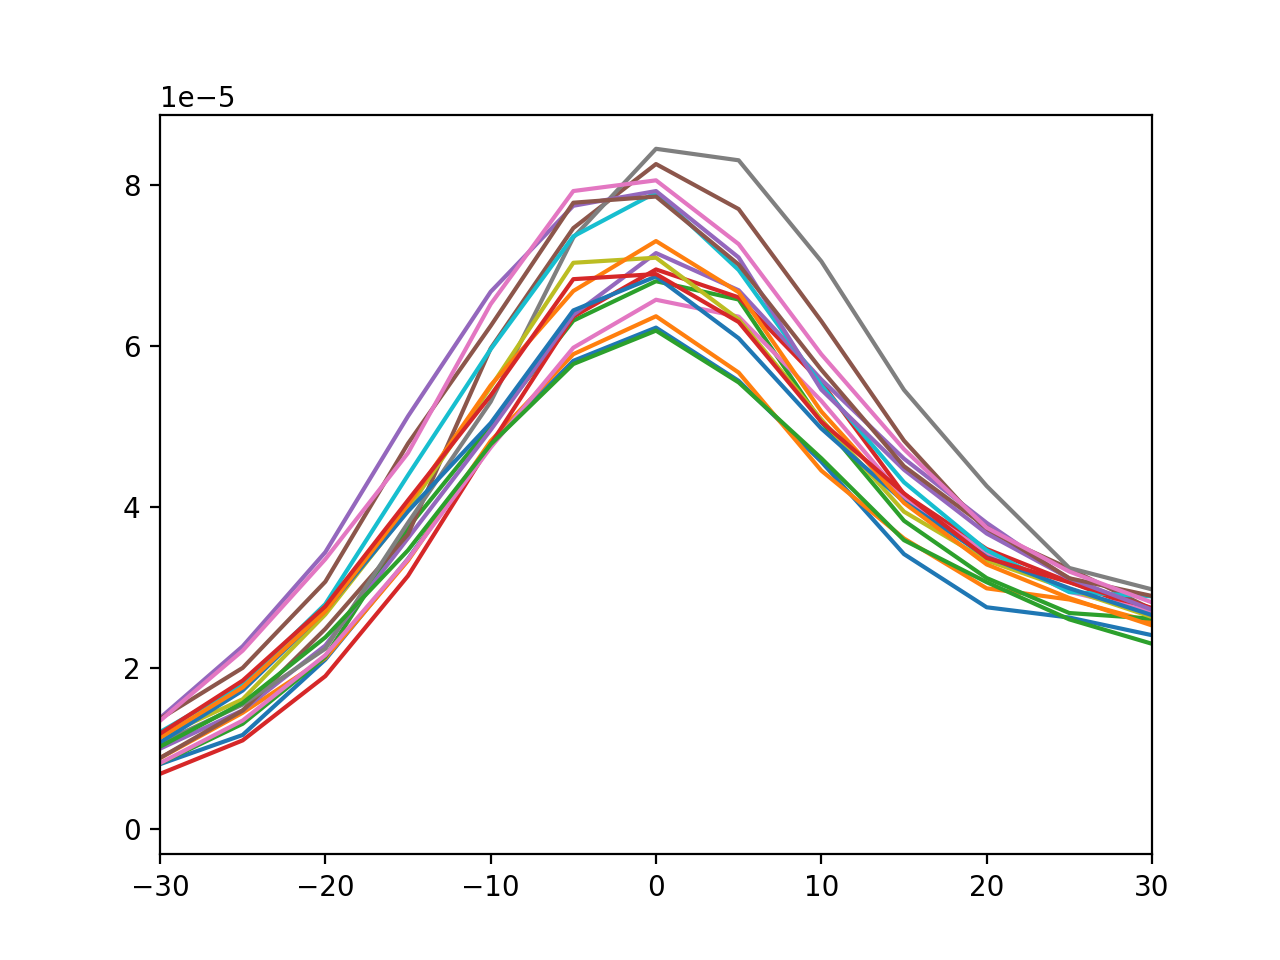

In [8]:
#all RIXS curves not normalized

plt.figure()
for i in range(len(T)):
    plt.plot(df["eloss_"+str(T[i])], df["intensity_"+str(T[i])])
    
plt.xlim(-30, 30)
plt.savefig('plots/RIXS_Tdep_stacked.png')
    
plt.show()

# Fitting

3. elastic (PseudoVoigt) + Two anti-Lor (one magnon + one continuum) + bg fit

In [9]:
#elastic (PseudoVoigt) + Two anti-Lor (magnon + continuum) + bg fit 
def Tdep3(params, x, y, T):
    '''
    Magnon's T-dep behavior for RIXS

    '''
    kB = 8.61733326e-2 # in meV/K
    
    a0 = params['El_ratio']
    A0 = params['El_area']
    w0 = params['El_wid']
    x0 = params['El_pk']

    A1 = params['Pk1_area']
    x1 = params['Pk1_pk']
    w1 = params['Pk1_wid']
    
    A2 = params['Pk2_area']
    x2 = params['Pk2_pk']
    w2 = params['Pk2_wid']
    
    bg = params['bg']
    
    sig0 = w0/(2*np.sqrt(2*np.log(2))) 
    elpk = a0*A0*np.exp(-(x-x0)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-a0)*A0*(w0/2)/np.pi/((x-x0)**2+(w0/2)**2) #pseudoVoigt
    
    antiLor1 = A1*1/(1-np.exp(-(x1-x0)/kB/T))*(w1/2)/np.pi/((x-(x1-x0))**2+(w1/2)**2)-A1*(w1/2)/np.pi/((x-x0+x1)**2+(w1/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = A2*(w2/2)/np.pi/((x+x0-x2)**2+(w2/2)**2)-A2*(w2/2)/np.pi/((x-x0+x2)**2+(w2/2)**2) #continuum without bose factor
    aLor2 = np.where(antiLor2<0, 0., antiLor2)
    
    bg = bg
    model = elpk+aLor1+aLor2+bg
    
    return model-y

def fit_Tdep3(x, y, T, plot_fit=False):
    # create a set of Parameters
    params = Parameters()
    params.add('El_area', value=2e-3, min=0.)
    params.add('El_wid', value=30, min=20, max=35)
    params.add('El_pk', value=0, min=-2, max=2)
    params.add('El_ratio', value=0.58926547, vary=False)
    
    params.add('Pk1_area', value=1e-3, min=0)
    params.add('Pk1_pk', value=30, min=20)
    params.add('Pk1_wid', value=40, min=25)
    
    params.add('Pk2_area', value=6e-3, min=0.)
    params.add('Pk2_pk', value=73, min=55, max = 200) #previous is 73, 45
    params.add('Pk2_wid', value=170, min=25, max=300)
    
    
    params.add('bg', value=1e-7, min=0, max=1e-6)
    
    # do fit, here with leastsq model
    
    minner = Minimizer(Tdep3, params, fcn_args=(x, y, T))
    result = minner.minimize()

    # calculate final result
    final = y + result.residual

    # write error report
    report_fit(result)

    #define fitted peaks
    kB = 8.61733326e-2 # in meV/K
    sig0 = result.params['El_wid'].value/(2*np.sqrt(2*np.log(2))) 
    elpk = result.params['El_ratio'].value*result.params['El_area'].value*np.exp(-(x-result.params['El_pk'].value)**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-result.params['El_ratio'].value)*result.params['El_area'].value*(result.params['El_wid'].value/2)/np.pi/((x-result.params['El_pk'].value)**2+(result.params['El_wid'].value/2)**2) #pseudoVoigt
    
    antiLor1 = result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x-(result.params['Pk1_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk1_wid'].value/2)**2)-result.params['Pk1_area'].value*1/(1-np.exp(-(result.params['Pk1_pk'].value-result.params['El_pk'].value)/kB/T))*(result.params['Pk1_wid'].value/2)/np.pi/((x+result.params['Pk1_pk'].value-result.params['El_pk'].value)**2+(result.params['Pk1_wid'].value/2)**2) #single magnon with bose factor
    aLor1 = np.where(antiLor1<0, 0, antiLor1)
    
    antiLor2 = result.params['Pk2_area'].value*(result.params['Pk2_wid'].value/2)/np.pi/((x-(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2)-result.params['Pk2_area'].value*(result.params['Pk2_wid'].value/2)/np.pi/((x+(result.params['Pk2_pk'].value-result.params['El_pk'].value))**2+(result.params['Pk2_wid'].value/2)**2) #continuum without bose factor
    aLor2 = np.where(antiLor2<0, 0., antiLor2)
    
    bg = result.params['bg'].value
    
    #export model
    df = pd.DataFrame({"eloss" : x, "elastic" : elpk+bg, "mag1" : aLor1+bg, "continuum" : aLor2+bg,
                      "total_model" : final, "total_data" : y, "residual" : result.residual})
    df.to_csv("YIO100nm_Tdep_fit_"+str(T)+"K.csv", index=False)
    
    # try to plot results
    try:
        if plot_fit:
            plt.figure()
            ax=plt.axes()
            plt.plot(x, y, 'ko')
            plt.plot(x, final, 'r-')
            plt.plot(x, result.residual, 'g-')
            plt.plot(x, elpk+bg, 'b--')
            plt.plot(x, aLor1+bg, 'b--')
            plt.plot(x, aLor2+bg, 'b--')
            plt.text(0.8, 0.5, str(T)+" K", horizontalalignment='center', 
                     verticalalignment='center', transform=ax.transAxes)
            plt.show()
    except ImportError:
        pass
    
    return final, result

# 1. Fitting with elastic peak width and energy being relaxed

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 183
    # data points      = 81
    # variables        = 10
    chi-square         = 2.7389e-11
    reduced chi-square = 3.8576e-13
    Akaike info crit   = -2305.94073
    Bayesian info crit = -2281.99624
[[Variables]]
    El_area:   0.00210453 +/- 3.0758e-05 (1.46%) (init = 0.002)
    El_wid:    28.0827148 +/- 0.40911781 (1.46%) (init = 30)
    El_pk:    -1.60840017 +/- 0.15075127 (9.37%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00139961 +/- 5.4761e-04 (39.13%) (init = 0.001)
    Pk1_pk:    33.5819071 +/- 1.47610852 (4.40%) (init = 30)
    Pk1_wid:   55.5054144 +/- 10.2846146 (18.53%) (init = 40)
    Pk2_area:  0.00669688 +/- 0.00436209 (65.14%) (init = 0.006)
    Pk2_pk:    55.0000003 +/- 32.6523195 (59.37%) (init = 73)
    Pk2_wid:   220.212182 +/- 19.7892245 (8.99%) (init = 170)
    bg:        8.9524e-07 +/- 2.0274e-07 (22.65%) (init = 1e-07)
[[Correlations]] (unreported correlations a

<IPython.core.display.Javascript object>


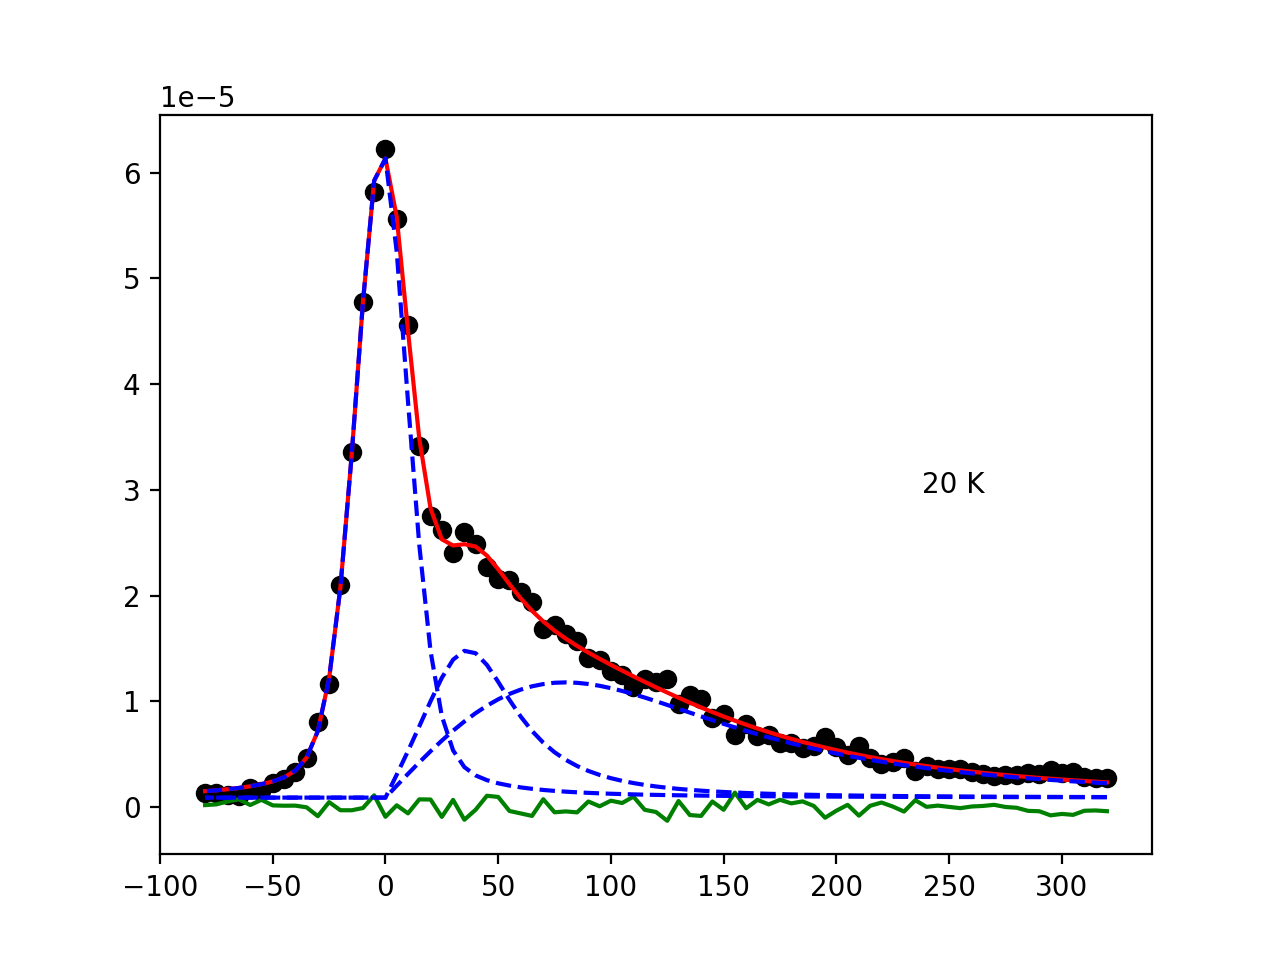

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 233
    # data points      = 81
    # variables        = 10
    chi-square         = 3.8695e-11
    reduced chi-square = 5.4501e-13
    Akaike info crit   = -2277.94966
    Bayesian info crit = -2254.00517
[[Variables]]
    El_area:   0.00214583 +/- 3.7464e-05 (1.75%) (init = 0.002)
    El_wid:    28.4964497 +/- 0.49051897 (1.72%) (init = 30)
    El_pk:    -1.64757740 +/- 0.18074139 (10.97%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00246227 +/- 7.8188e-04 (31.75%) (init = 0.001)
    Pk1_pk:    34.8486558 +/- 1.96632380 (5.64%) (init = 30)
    Pk1_wid:   70.4192483 +/- 11.5725025 (16.43%) (init = 40)
    Pk2_area:  0.00363547 +/- 0.00172879 (47.55%) (init = 0.006)
    Pk2_pk:    88.2138238 +/- 25.6874853 (29.12%) (init = 73)
    Pk2_wid:   216.480543 +/- 27.7368773 (12.81%) (init = 170)
    bg:        9.6302e-07 +/- 2.4545e-07 (25.49%) (init = 1e-07)
[[Correlations]] (unreported correlations

<IPython.core.display.Javascript object>


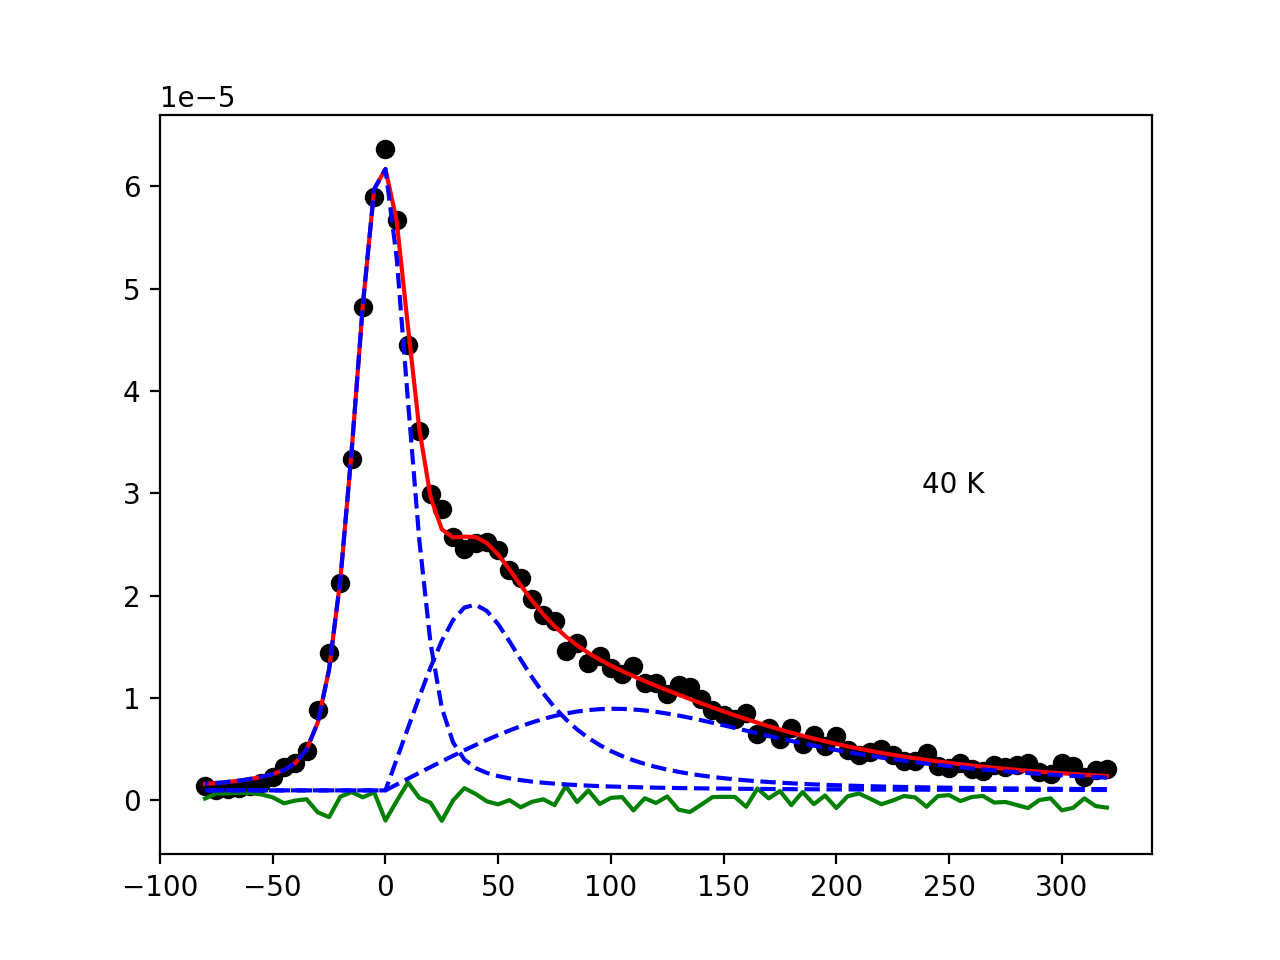

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 81
    # variables        = 10
    chi-square         = 3.4637e-11
    reduced chi-square = 4.8785e-13
    Akaike info crit   = -2286.92418
    Bayesian info crit = -2262.97968
[[Variables]]
    El_area:   0.00238383 +/- 3.3920e-05 (1.42%) (init = 0.002)
    El_wid:    28.7188686 +/- 0.40366024 (1.41%) (init = 30)
    El_pk:    -0.87615379 +/- 0.14937811 (17.05%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00155056 +/- 5.2388e-04 (33.79%) (init = 0.001)
    Pk1_pk:    37.4728329 +/- 1.37764013 (3.68%) (init = 30)
    Pk1_wid:   56.5890857 +/- 9.54654568 (16.87%) (init = 40)
    Pk2_area:  0.00604579 +/- 0.00368871 (61.01%) (init = 0.006)
    Pk2_pk:    65.0371037 +/- 30.9292739 (47.56%) (init = 73)
    Pk2_wid:   230.946607 +/- 24.3798388 (10.56%) (init = 170)
    bg:        7.8241e-07 +/- 2.2989e-07 (29.38%) (init = 1e-07)
[[Correlations]] (unreported correlations

<IPython.core.display.Javascript object>


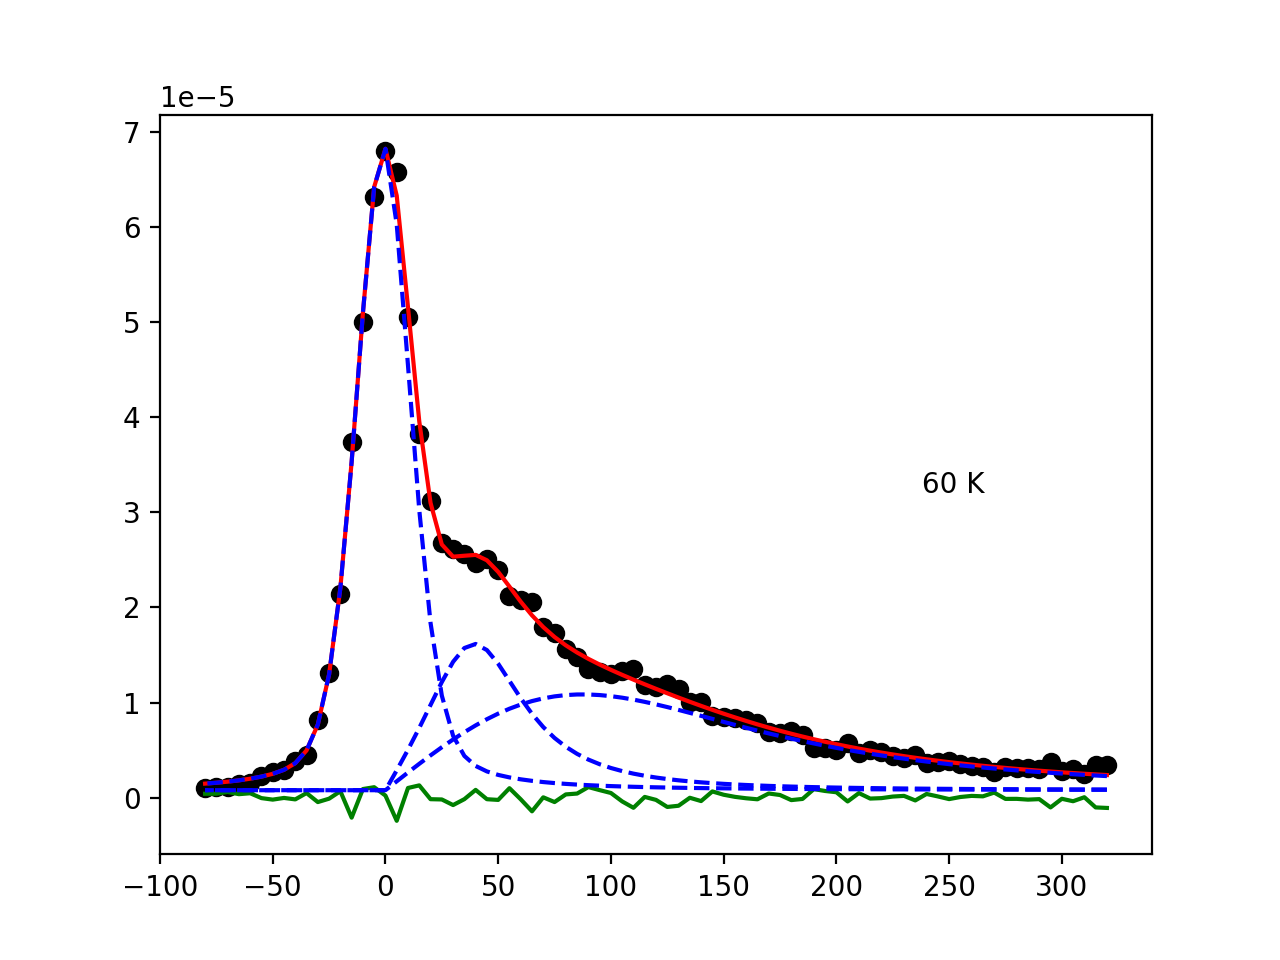

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 228
    # data points      = 81
    # variables        = 10
    chi-square         = 2.4446e-11
    reduced chi-square = 3.4431e-13
    Akaike info crit   = -2315.14918
    Bayesian info crit = -2291.20469
[[Variables]]
    El_area:   0.00223803 +/- 4.9616e-05 (2.22%) (init = 0.002)
    El_wid:    26.9862533 +/- 0.33002707 (1.22%) (init = 30)
    El_pk:    -0.55306275 +/- 0.26521409 (47.95%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00391189 +/- 0.00201151 (51.42%) (init = 0.001)
    Pk1_pk:    22.9528536 +/- 5.83563019 (25.42%) (init = 30)
    Pk1_wid:   89.7354206 +/- 16.6520949 (18.56%) (init = 40)
    Pk2_area:  0.00686633 +/- 0.00790182 (115.08%) (init = 0.006)
    Pk2_pk:    55.0000055 +/- 26.0933603 (47.44%) (init = 73)
    Pk2_wid:   265.472799 +/- 27.8860042 (10.50%) (init = 170)
    bg:        9.3862e-07 +/- 1.9599e-07 (20.88%) (init = 1e-07)
[[Correlations]] (unreported correlatio

<IPython.core.display.Javascript object>


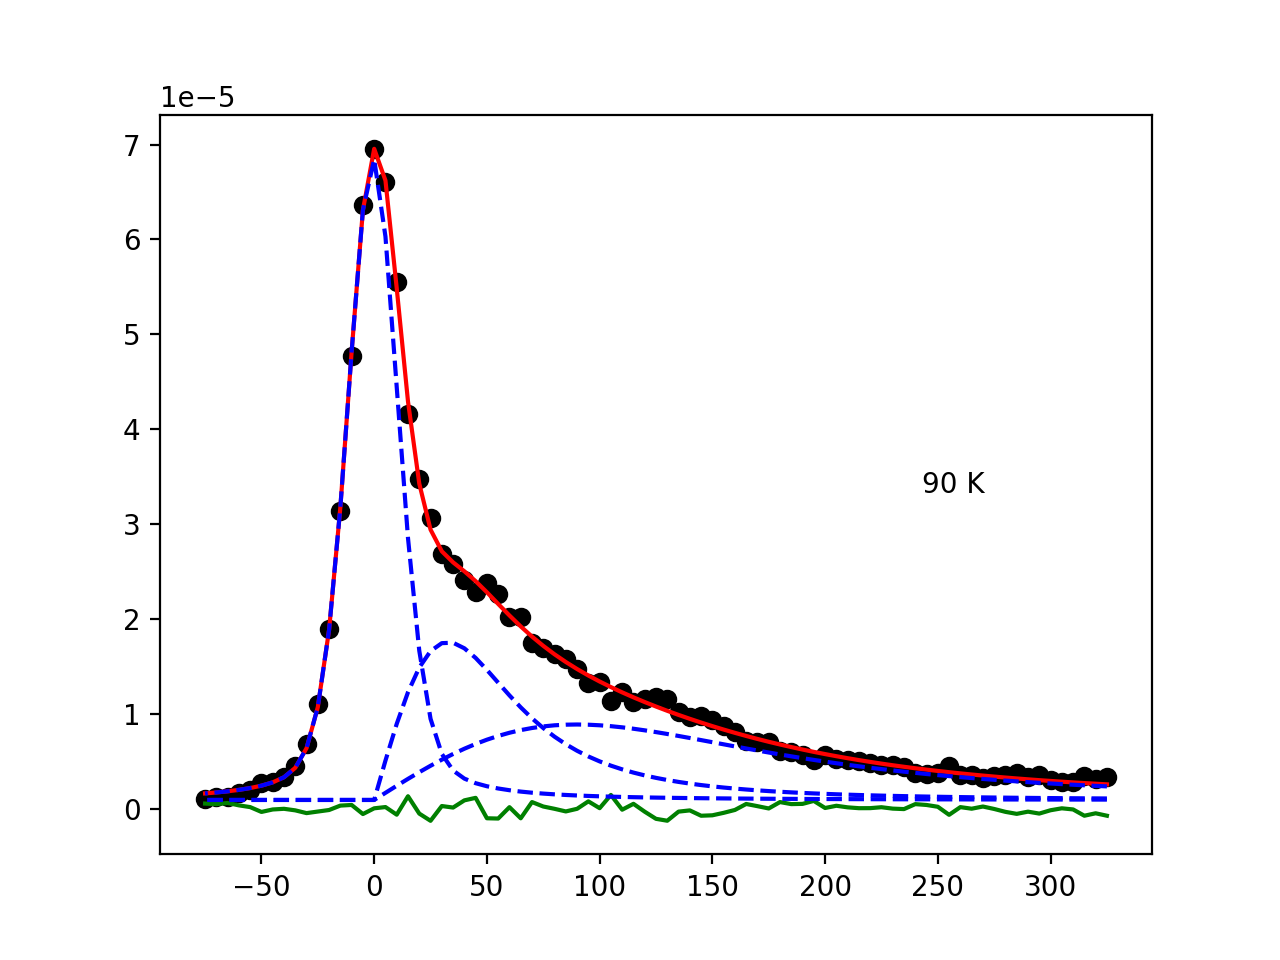

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4152
    # data points      = 81
    # variables        = 10
    chi-square         = 3.2841e-11
    reduced chi-square = 4.6255e-13
    Akaike info crit   = -2291.23679
    Bayesian info crit = -2267.29230
[[Variables]]
    El_area:   0.00254451 +/- 5.4301e-05 (2.13%) (init = 0.002)
    El_wid:    30.3716905 +/- 0.54361916 (1.79%) (init = 30)
    El_pk:    -0.11011944 +/- 0.25288506 (229.65%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00139475 +/- 6.3512e-04 (45.54%) (init = 0.001)
    Pk1_pk:    33.7745642 +/- 2.52571395 (7.48%) (init = 30)
    Pk1_wid:   56.1931692 +/- 12.6611511 (22.53%) (init = 40)
    Pk2_area:  0.00757004 +/- 0.00621975 (82.16%) (init = 0.006)
    Pk2_pk:    55.0014661 +/- 36.8151913 (66.93%) (init = 73)
    Pk2_wid:   236.189753 +/- 24.6063949 (10.42%) (init = 170)
    bg:        1.0000e-06 +/- 3.7014e-07 (37.01%) (init = 1e-07)
[[Correlations]] (unreported correlatio

<IPython.core.display.Javascript object>


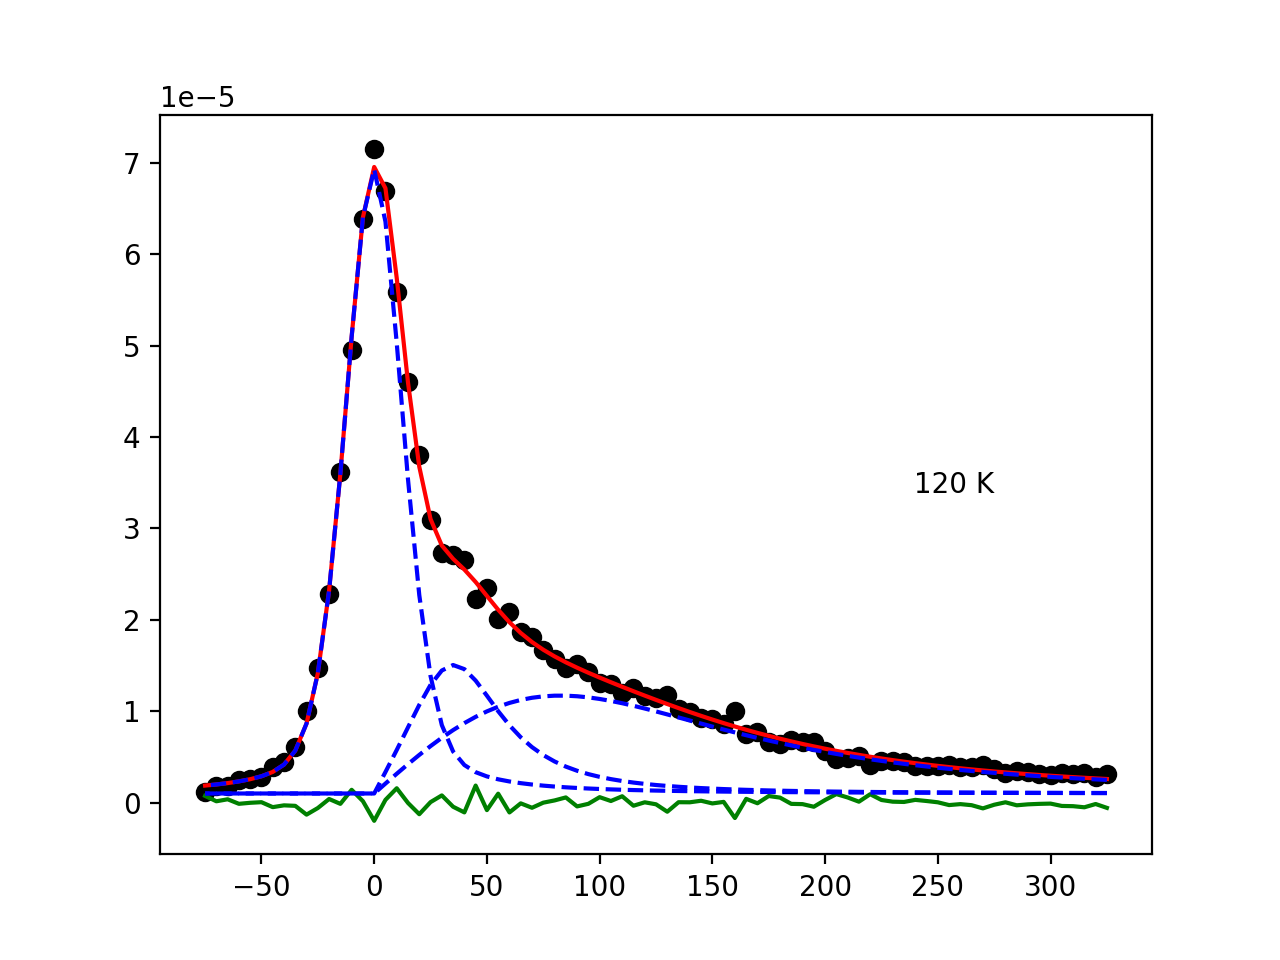

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 213
    # data points      = 81
    # variables        = 10
    chi-square         = 3.2635e-11
    reduced chi-square = 4.5965e-13
    Akaike info crit   = -2291.74695
    Bayesian info crit = -2267.80246
[[Variables]]
    El_area:   0.00276933 +/- 4.7600e-05 (1.72%) (init = 0.002)
    El_wid:    27.9694397 +/- 0.40204204 (1.44%) (init = 30)
    El_pk:    -0.46112932 +/- 0.18791005 (40.75%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00364294 +/- 0.00172183 (47.26%) (init = 0.001)
    Pk1_pk:    30.4310411 +/- 5.25223722 (17.26%) (init = 30)
    Pk1_wid:   87.0668981 +/- 18.3717514 (21.10%) (init = 40)
    Pk2_area:  0.00296242 +/- 0.00147088 (49.65%) (init = 0.006)
    Pk2_pk:    103.154756 +/- 26.1356940 (25.34%) (init = 73)
    Pk2_wid:   218.505875 +/- 29.6441524 (13.57%) (init = 170)
    bg:        9.3104e-07 +/- 2.3796e-07 (25.56%) (init = 1e-07)
[[Correlations]] (unreported correlation

<IPython.core.display.Javascript object>


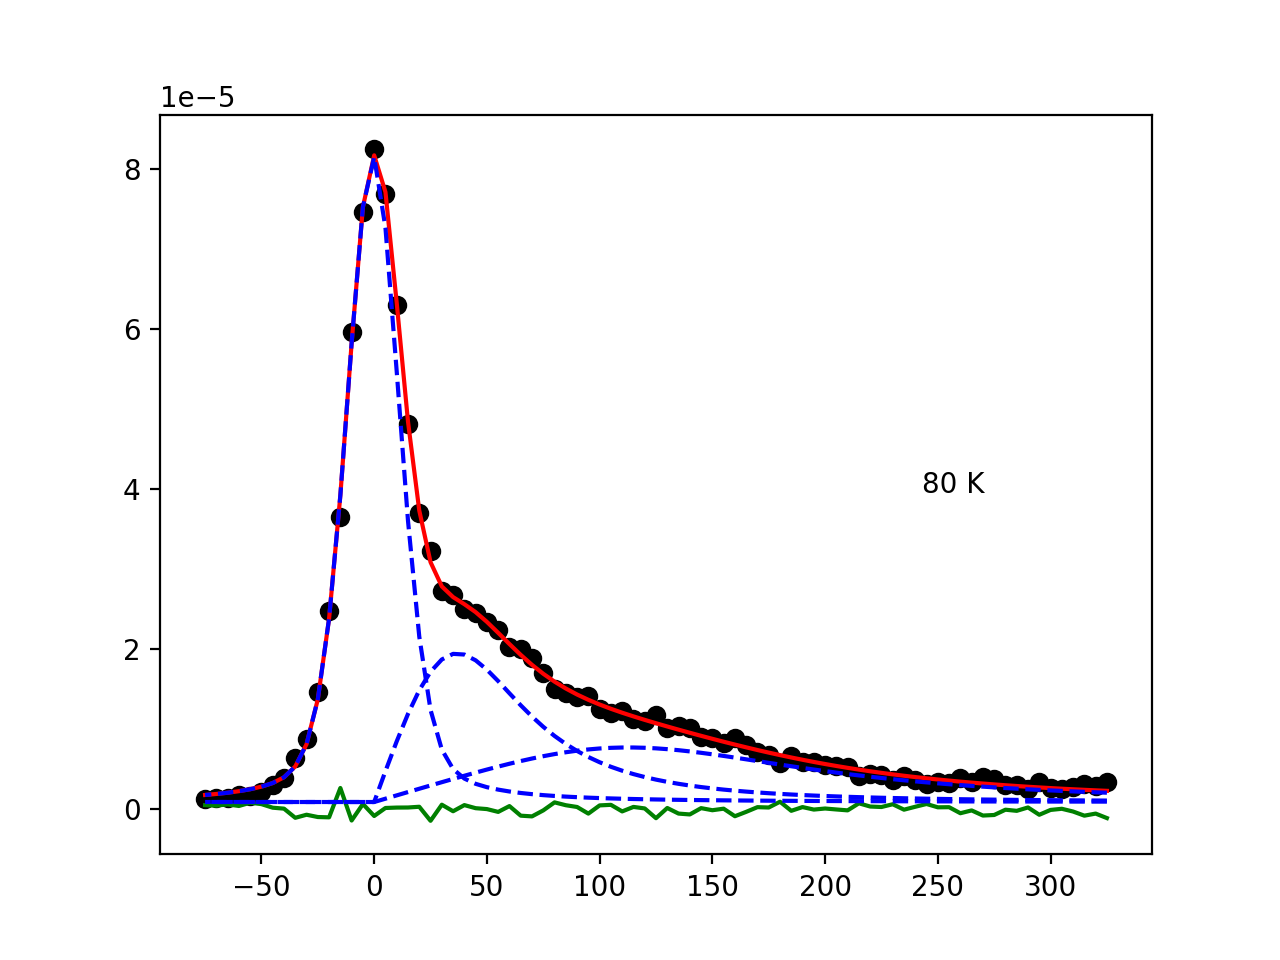

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1257
    # data points      = 81
    # variables        = 10
    chi-square         = 2.0245e-11
    reduced chi-square = 2.8513e-13
    Akaike info crit   = -2330.42437
    Bayesian info crit = -2306.47988
##  Warning: uncertainties could not be estimated:
    Pk1_pk:    at boundary
    bg:        at boundary
[[Variables]]
    El_area:   0.00222695 (init = 0.002)
    El_wid:    29.1697285 (init = 30)
    El_pk:    -0.99324078 (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00627110 (init = 0.001)
    Pk1_pk:    20.0000001 (init = 30)
    Pk1_wid:   112.484710 (init = 40)
    Pk2_area:  0.00205059 (init = 0.006)
    Pk2_pk:    117.620373 (init = 73)
    Pk2_wid:   209.937709 (init = 170)
    bg:        1.0000e-06 (init = 1e-07)


<IPython.core.display.Javascript object>


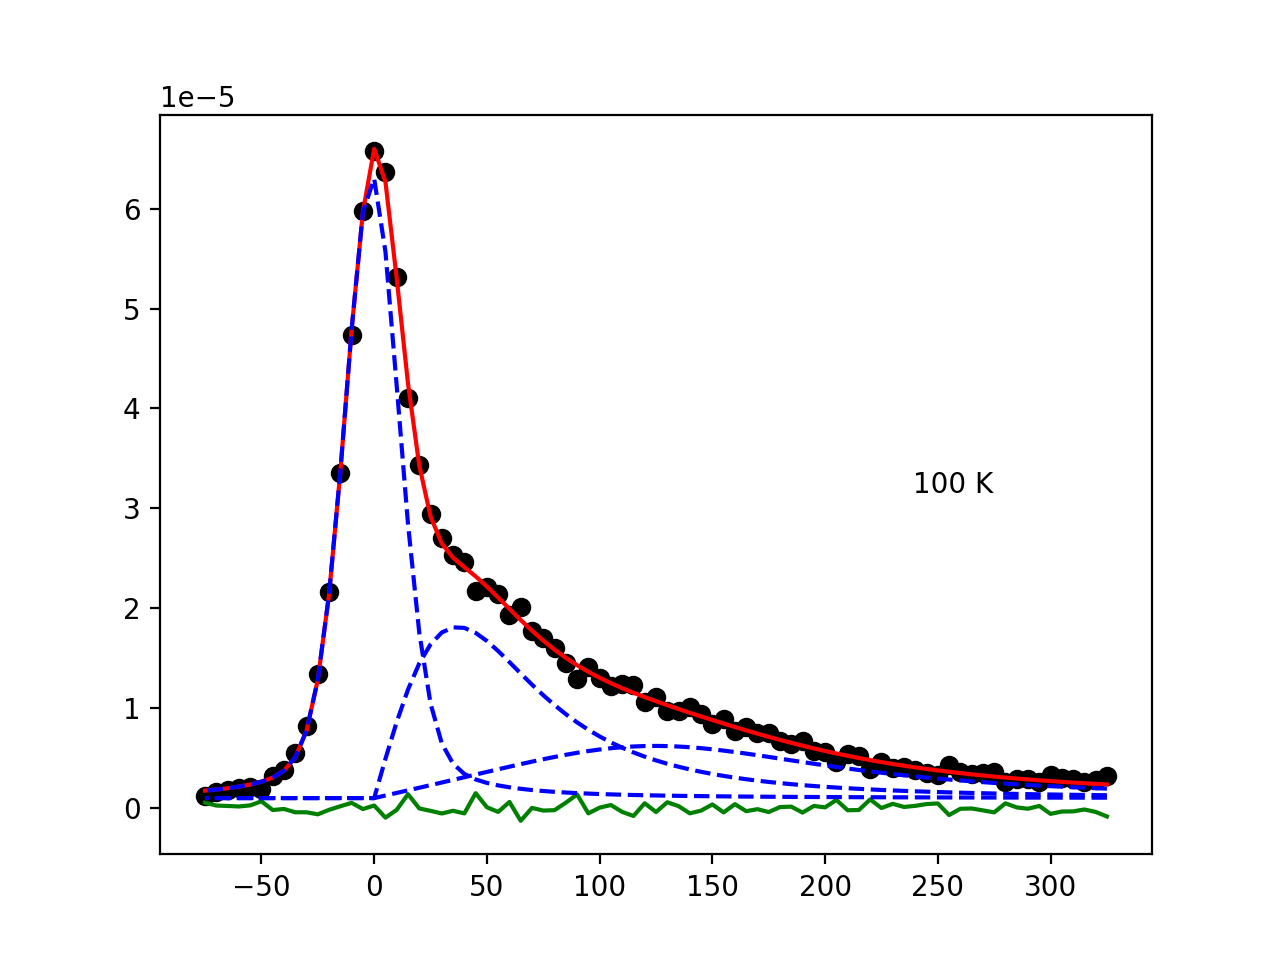

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22000
    # data points      = 81
    # variables        = 10
    chi-square         = 3.6023e-11
    reduced chi-square = 5.0736e-13
    Akaike info crit   = -2283.74696
    Bayesian info crit = -2259.80247
##  Warning: uncertainties could not be estimated:
    bg:        at boundary
[[Variables]]
    El_area:   0.00300591 (init = 0.002)
    El_wid:    29.5908023 (init = 30)
    El_pk:     1.27414266 (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00139646 (init = 0.001)
    Pk1_pk:    39.2514818 (init = 30)
    Pk1_wid:   55.7309355 (init = 40)
    Pk2_area:  0.00677592 (init = 0.006)
    Pk2_pk:    57.1341046 (init = 73)
    Pk2_wid:   236.038491 (init = 170)
    bg:        1.0000e-06 (init = 1e-07)


<IPython.core.display.Javascript object>


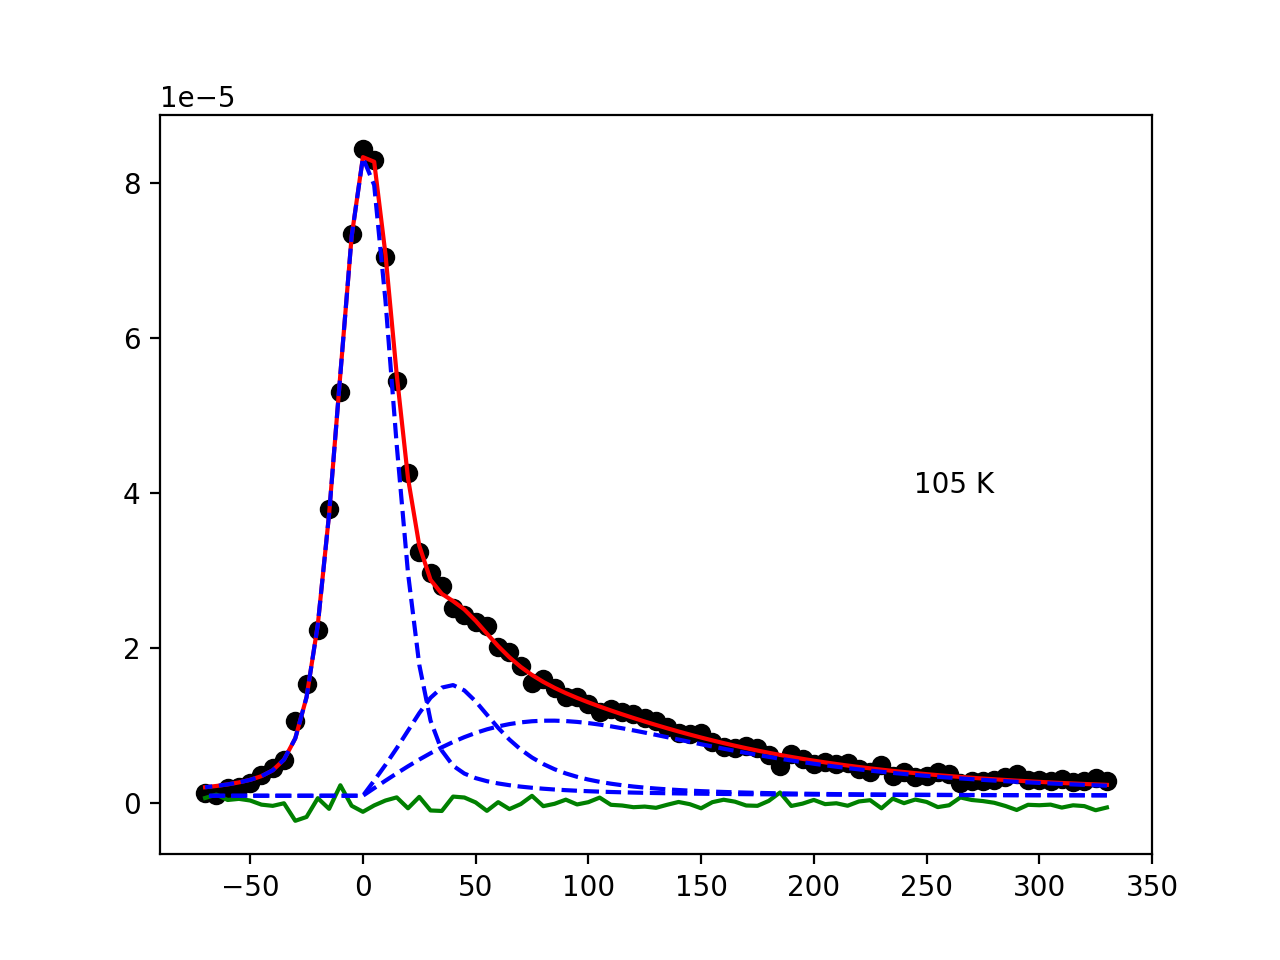

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1481
    # data points      = 81
    # variables        = 10
    chi-square         = 3.8384e-11
    reduced chi-square = 5.4062e-13
    Akaike info crit   = -2278.60486
    Bayesian info crit = -2254.66036
[[Variables]]
    El_area:   0.00249383 +/- 4.7928e-05 (1.92%) (init = 0.002)
    El_wid:    29.0432948 +/- 0.51091184 (1.76%) (init = 30)
    El_pk:    -2.00000000 +/- 6.63756821 (331.88%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00125078 +/- 5.2582e-04 (42.04%) (init = 0.001)
    Pk1_pk:    29.1382106 +/- 2.14854336 (7.37%) (init = 30)
    Pk1_wid:   51.1919134 +/- 11.1491998 (21.78%) (init = 40)
    Pk2_area:  0.00688204 +/- 0.00428457 (62.26%) (init = 0.006)
    Pk2_pk:    55.0000627 +/- 26.4272747 (48.05%) (init = 73)
    Pk2_wid:   217.185805 +/- 22.3257408 (10.28%) (init = 170)
    bg:        1.0000e-06 +/- 4.5327e-07 (45.33%) (init = 1e-07)
[[Correlations]] (unreported correlatio

<IPython.core.display.Javascript object>


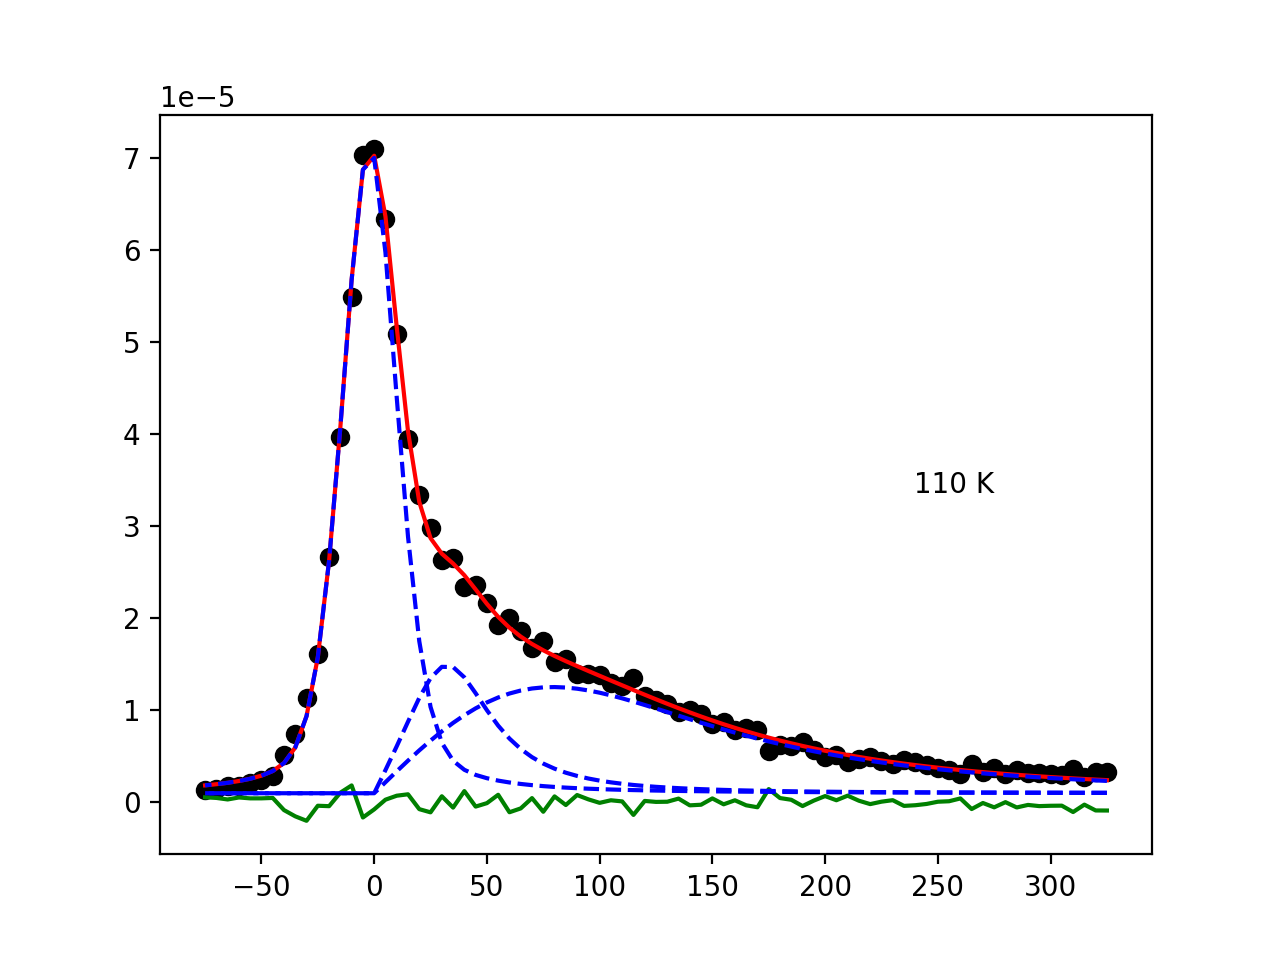

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1072
    # data points      = 81
    # variables        = 10
    chi-square         = 3.8364e-11
    reduced chi-square = 5.4034e-13
    Akaike info crit   = -2278.64600
    Bayesian info crit = -2254.70151
[[Variables]]
    El_area:   0.00275622 +/- 4.3210e-05 (1.57%) (init = 0.002)
    El_wid:    29.4786841 +/- 0.43430704 (1.47%) (init = 30)
    El_pk:    -1.67360399 +/- 0.17114482 (10.23%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00109259 +/- 4.3110e-04 (39.46%) (init = 0.001)
    Pk1_pk:    31.6466110 +/- 1.66920462 (5.27%) (init = 30)
    Pk1_wid:   47.3070578 +/- 9.75073577 (20.61%) (init = 40)
    Pk2_area:  0.00677981 +/- 0.00395135 (58.28%) (init = 0.006)
    Pk2_pk:    55.0001145 +/- 25.3174882 (46.03%) (init = 73)
    Pk2_wid:   210.765978 +/- 21.1388591 (10.03%) (init = 170)
    bg:        1.0000e-06 +/- 1.6016e-07 (16.02%) (init = 1e-07)
[[Correlations]] (unreported correlation

<IPython.core.display.Javascript object>


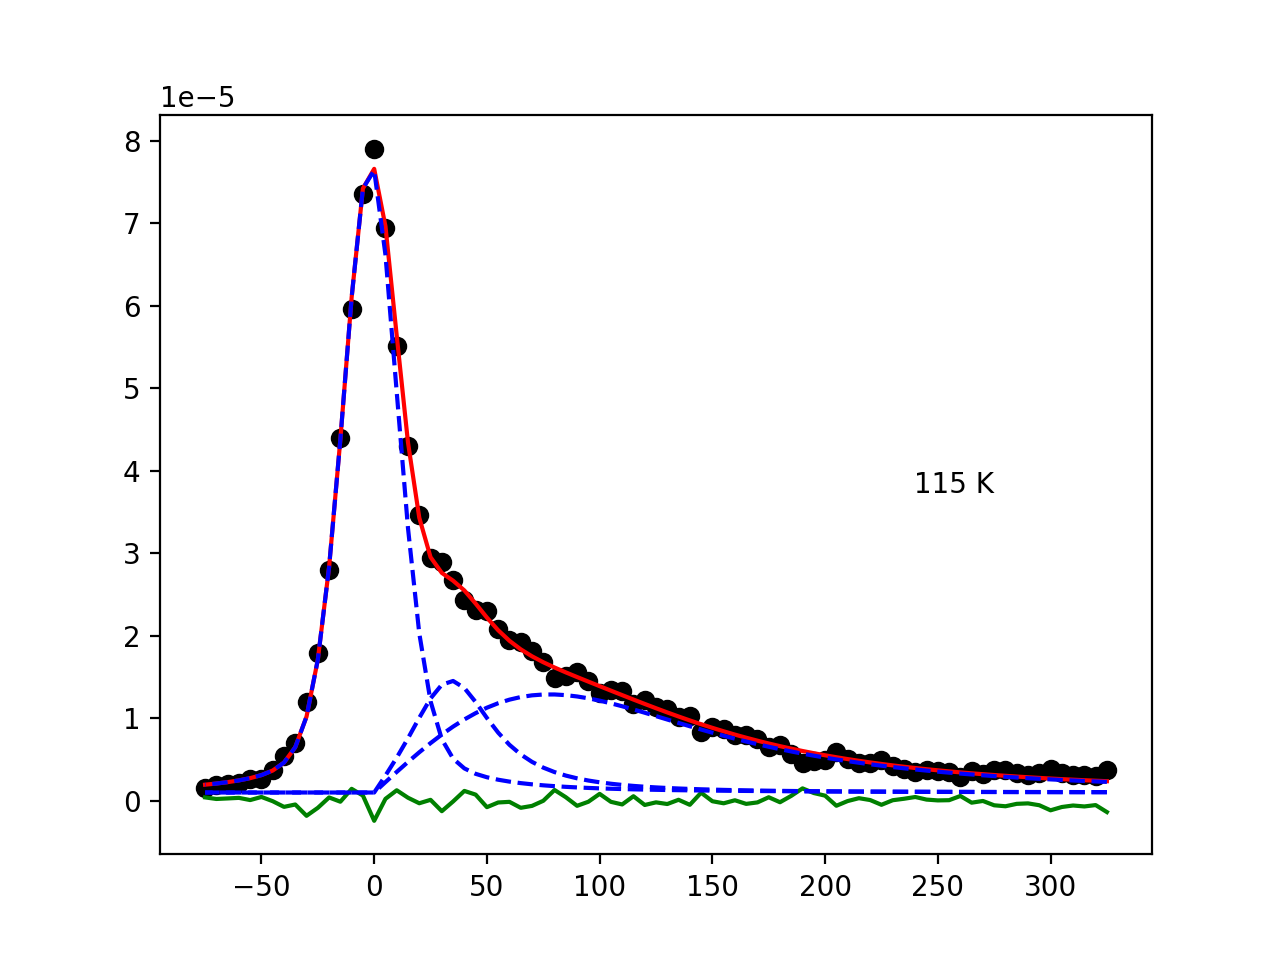

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1555
    # data points      = 81
    # variables        = 10
    chi-square         = 5.6735e-11
    reduced chi-square = 7.9909e-13
    Akaike info crit   = -2246.95313
    Bayesian info crit = -2223.00864
[[Variables]]
    El_area:   0.00247902 +/- 7.7501e-05 (3.13%) (init = 0.002)
    El_wid:    30.9992754 +/- 0.81284061 (2.62%) (init = 30)
    El_pk:    -1.63523113 +/- 0.38143686 (23.33%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00105270 +/- 8.2187e-04 (78.07%) (init = 0.001)
    Pk1_pk:    29.1992342 +/- 4.16089561 (14.25%) (init = 30)
    Pk1_wid:   53.1801073 +/- 20.2976754 (38.17%) (init = 40)
    Pk2_area:  0.00672879 +/- 0.00523519 (77.80%) (init = 0.006)
    Pk2_pk:    55.0000000 +/- 2027.43319 (3686.24%) (init = 73)
    Pk2_wid:   206.326031 +/- 25.3688027 (12.30%) (init = 170)
    bg:        1.0000e-06 +/- 4.5016e-07 (45.02%) (init = 1e-07)
[[Correlations]] (unreported correlat

<IPython.core.display.Javascript object>


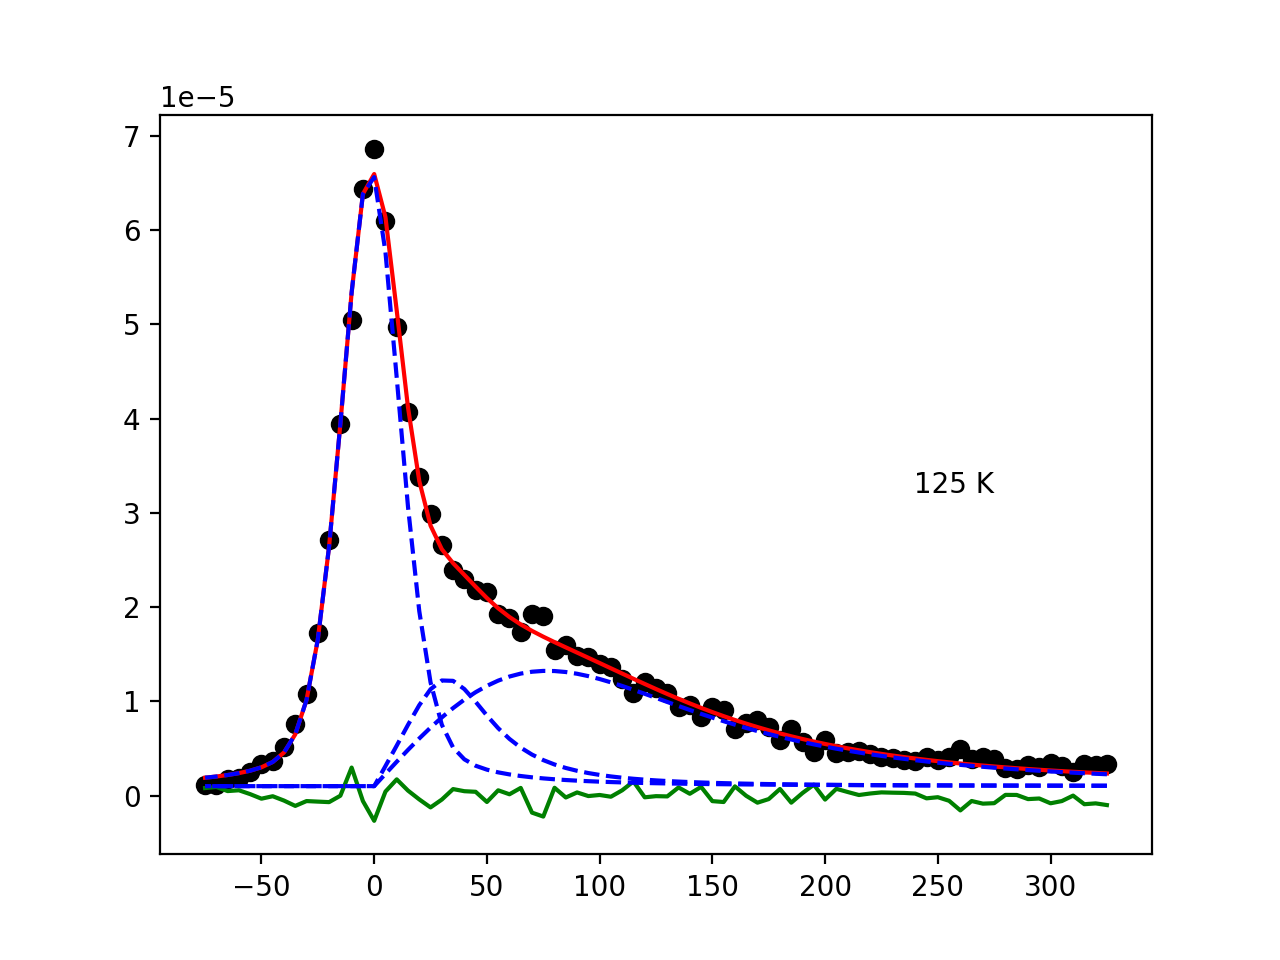

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 627
    # data points      = 81
    # variables        = 10
    chi-square         = 4.2132e-11
    reduced chi-square = 5.9341e-13
    Akaike info crit   = -2271.05782
    Bayesian info crit = -2247.11332
[[Variables]]
    El_area:   0.00262876 +/- 5.0367e-05 (1.92%) (init = 0.002)
    El_wid:    30.6131578 +/- 0.52472440 (1.71%) (init = 30)
    El_pk:    -1.34161561 +/- 0.21680901 (16.16%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00127267 +/- 7.5279e-04 (59.15%) (init = 0.001)
    Pk1_pk:    34.9906549 +/- 2.48817857 (7.11%) (init = 30)
    Pk1_wid:   58.7899024 +/- 16.4709470 (28.02%) (init = 40)
    Pk2_area:  0.00620365 +/- 0.00646969 (104.29%) (init = 0.006)
    Pk2_pk:    56.3765956 +/- 48.4917861 (86.01%) (init = 73)
    Pk2_wid:   231.845930 +/- 31.3404358 (13.52%) (init = 170)
    bg:        1.0000e-06 +/- 2.4409e-07 (24.41%) (init = 1e-07)
[[Correlations]] (unreported correlation

<IPython.core.display.Javascript object>


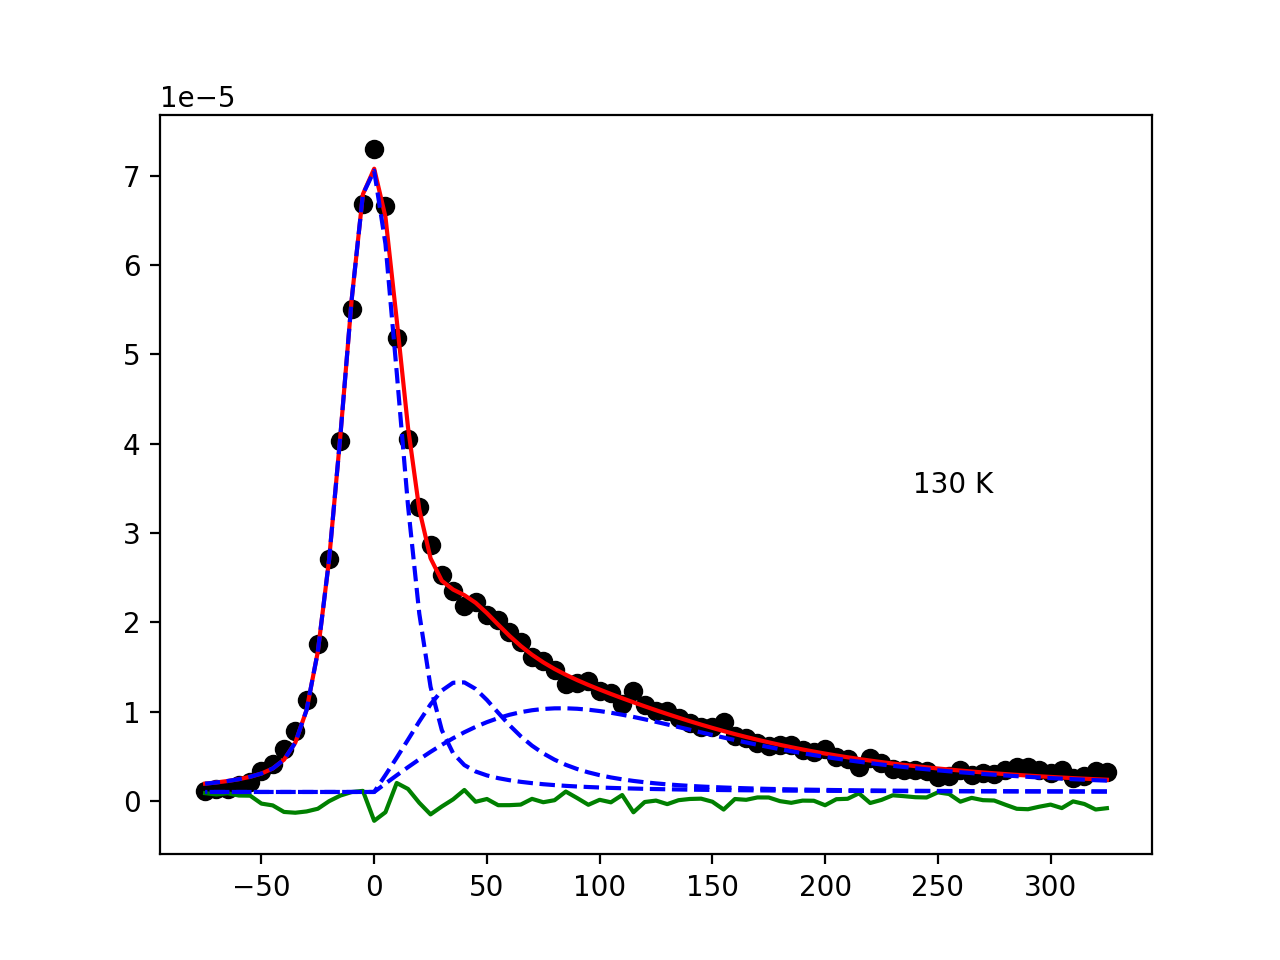

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2522
    # data points      = 81
    # variables        = 10
    chi-square         = 3.5037e-11
    reduced chi-square = 4.9347e-13
    Akaike info crit   = -2285.99538
    Bayesian info crit = -2262.05089
[[Variables]]
    El_area:   0.00224833 +/- 5.5581e-05 (2.47%) (init = 0.002)
    El_wid:    30.9357506 +/- 0.64999983 (2.10%) (init = 30)
    El_pk:    -1.55442953 +/- 0.29437859 (18.94%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00101164 +/- 6.7533e-04 (66.76%) (init = 0.001)
    Pk1_pk:    31.5250177 +/- 3.16339110 (10.03%) (init = 30)
    Pk1_wid:   55.4023776 +/- 17.8303898 (32.18%) (init = 40)
    Pk2_area:  0.00616683 +/- 0.00487348 (79.03%) (init = 0.006)
    Pk2_pk:    55.0000000 +/- 1141.41772 (2075.30%) (init = 73)
    Pk2_wid:   214.630048 +/- 24.1472583 (11.25%) (init = 170)
    bg:        1.0000e-06 +/- 5.6525e-10 (0.06%) (init = 1e-07)
[[Correlations]] (unreported correlati

<IPython.core.display.Javascript object>


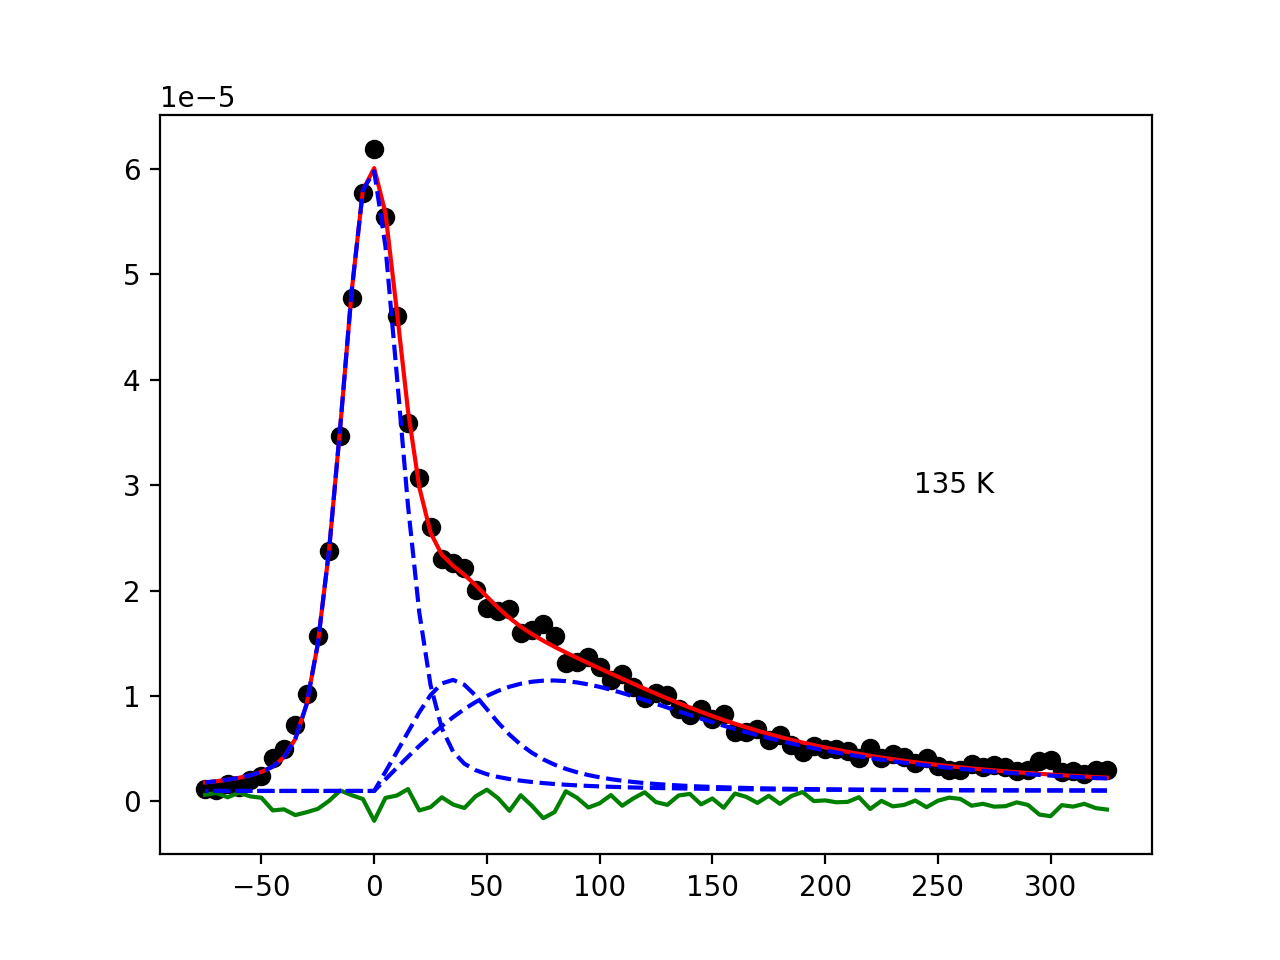

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1026
    # data points      = 81
    # variables        = 10
    chi-square         = 4.0732e-11
    reduced chi-square = 5.7368e-13
    Akaike info crit   = -2273.79575
    Bayesian info crit = -2249.85126
[[Variables]]
    El_area:   0.00256333 +/- 5.9570e-05 (2.32%) (init = 0.002)
    El_wid:    30.9488307 +/- 0.61768683 (2.00%) (init = 30)
    El_pk:    -1.93178034 +/- 0.27740003 (14.36%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  0.00109724 +/- 5.3222e-04 (48.50%) (init = 0.001)
    Pk1_pk:    29.5680422 +/- 2.51442472 (8.50%) (init = 30)
    Pk1_wid:   50.1307680 +/- 12.4907594 (24.92%) (init = 40)
    Pk2_area:  0.00632757 +/- 0.00424945 (67.16%) (init = 0.006)
    Pk2_pk:    55.0000023 +/- 30.0318315 (54.60%) (init = 73)
    Pk2_wid:   210.595587 +/- 23.7784836 (11.29%) (init = 170)
    bg:        1.0000e-06 +/- 2.3386e-08 (2.34%) (init = 1e-07)
[[Correlations]] (unreported correlations

<IPython.core.display.Javascript object>


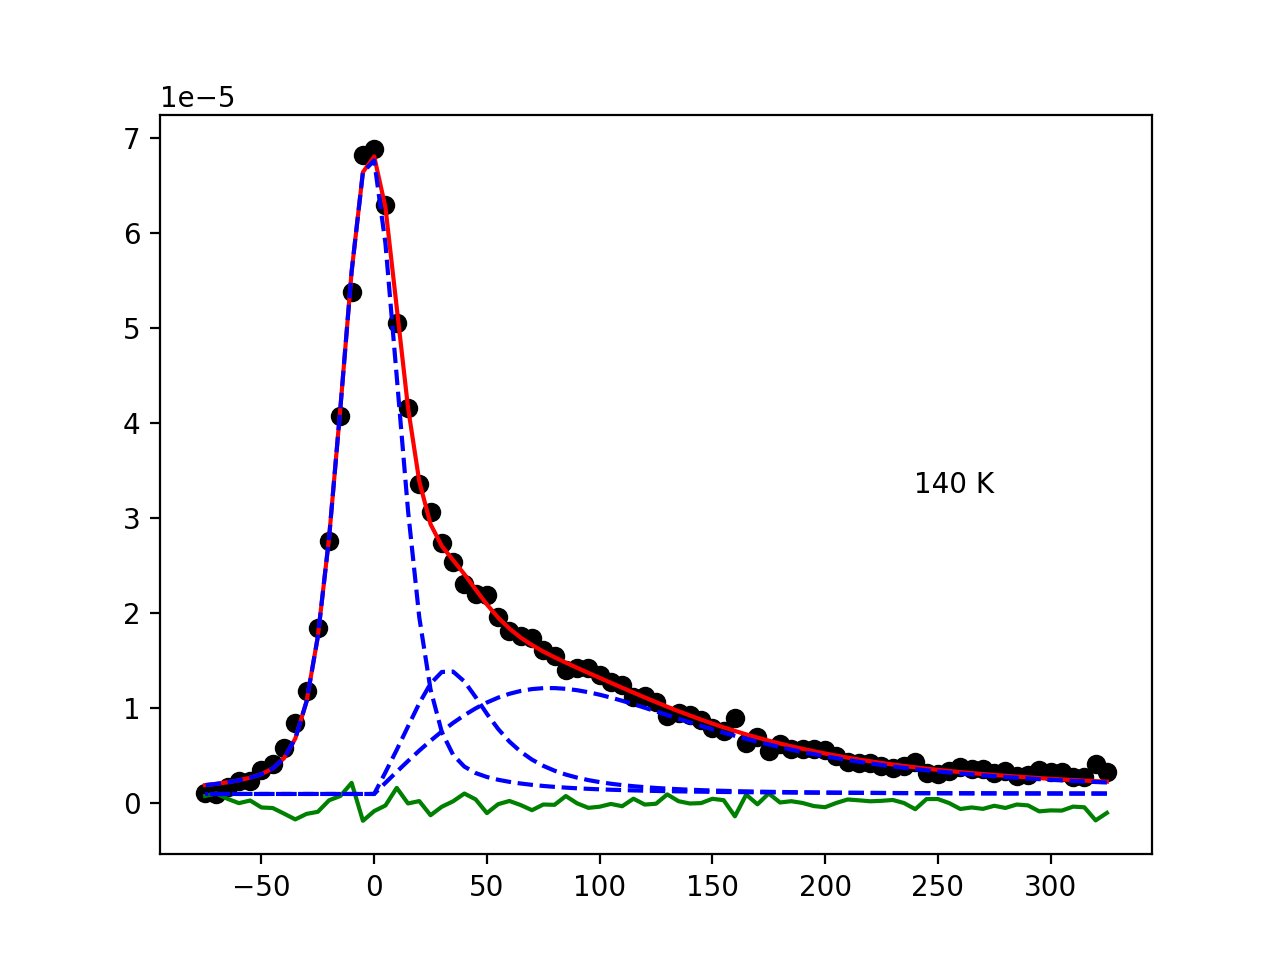

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 473
    # data points      = 81
    # variables        = 10
    chi-square         = 5.1833e-11
    reduced chi-square = 7.3005e-13
    Akaike info crit   = -2254.27227
    Bayesian info crit = -2230.32778
[[Variables]]
    El_area:   0.00309842 +/- 4.4538e-05 (1.44%) (init = 0.002)
    El_wid:    32.3506766 +/- 0.45456892 (1.41%) (init = 30)
    El_pk:    -2.00000000 +/- 1.42035371 (71.02%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  5.8756e-04 +/- 2.6326e-04 (44.81%) (init = 0.001)
    Pk1_pk:    32.7262212 +/- 1.53147681 (4.68%) (init = 30)
    Pk1_wid:   35.2634944 +/- 8.93091548 (25.33%) (init = 40)
    Pk2_area:  0.00621732 +/- 0.00291989 (46.96%) (init = 0.006)
    Pk2_pk:    55.0000001 +/- 21.3039793 (38.73%) (init = 73)
    Pk2_wid:   189.315898 +/- 20.0514463 (10.59%) (init = 170)
    bg:        1.0000e-06 +/- 2.6731e-07 (26.73%) (init = 1e-07)
[[Correlations]] (unreported correlations

<IPython.core.display.Javascript object>


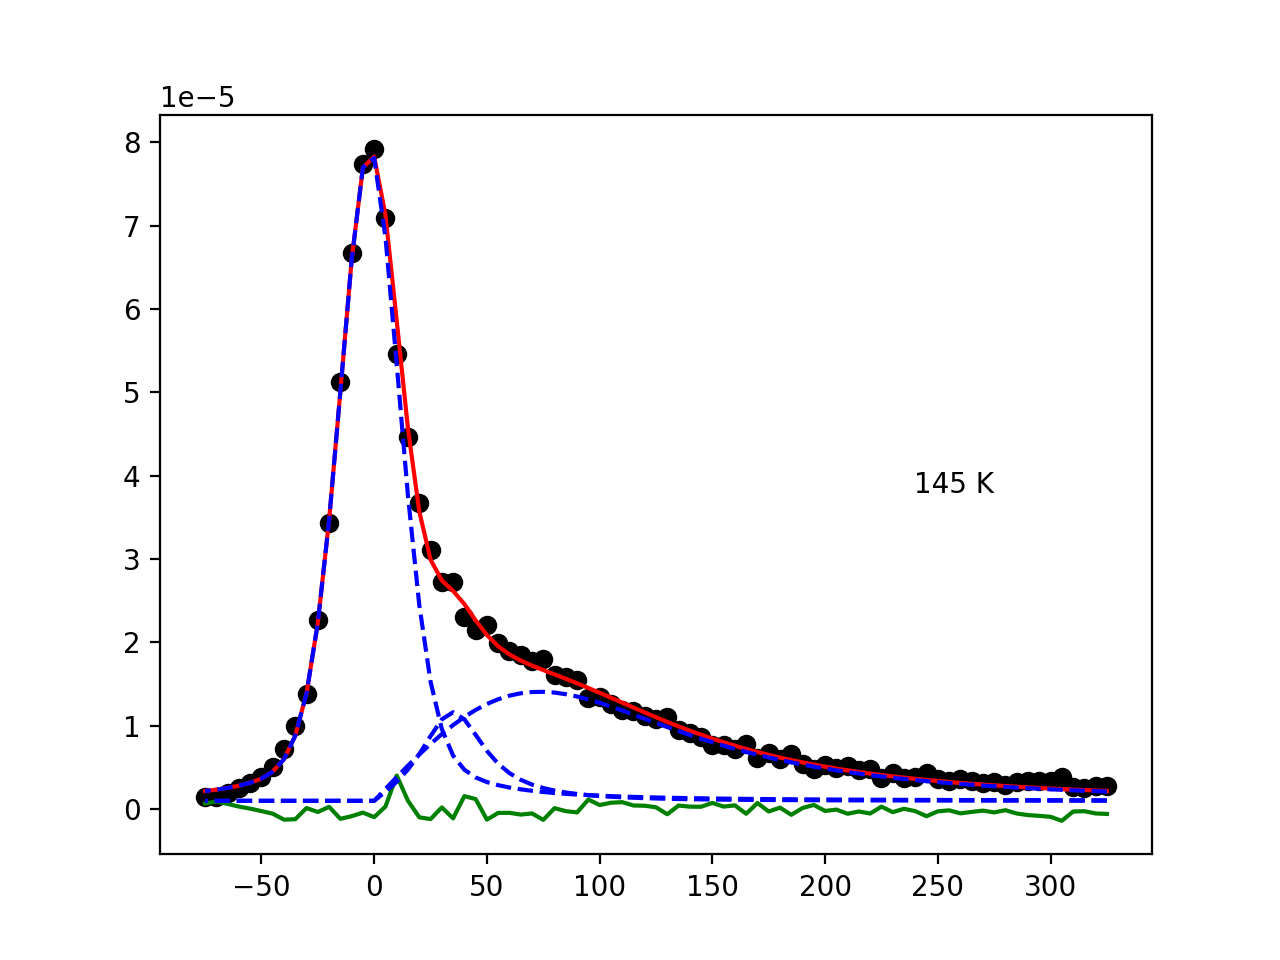

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2132
    # data points      = 81
    # variables        = 10
    chi-square         = 3.9217e-11
    reduced chi-square = 5.5235e-13
    Akaike info crit   = -2276.86486
    Bayesian info crit = -2252.92036
[[Variables]]
    El_area:   0.00292526 +/- 5.2733e-05 (1.80%) (init = 0.002)
    El_wid:    30.8094404 +/- 0.49339045 (1.60%) (init = 30)
    El_pk:    -2.00000000 +/- 78.2038610 (3910.19%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  8.1881e-04 +/- 3.0426e-04 (37.16%) (init = 0.001)
    Pk1_pk:    28.4864170 +/- 1.88020506 (6.60%) (init = 30)
    Pk1_wid:   41.4010543 +/- 8.67429767 (20.95%) (init = 40)
    Pk2_area:  0.00670908 +/- 0.00309934 (46.20%) (init = 0.006)
    Pk2_pk:    55.0000786 +/- 19.7384898 (35.89%) (init = 73)
    Pk2_wid:   203.567757 +/- 19.3989203 (9.53%) (init = 170)
    bg:        1.0000e-06 +/- 1.9289e-06 (192.89%) (init = 1e-07)
[[Correlations]] (unreported correlati

<IPython.core.display.Javascript object>


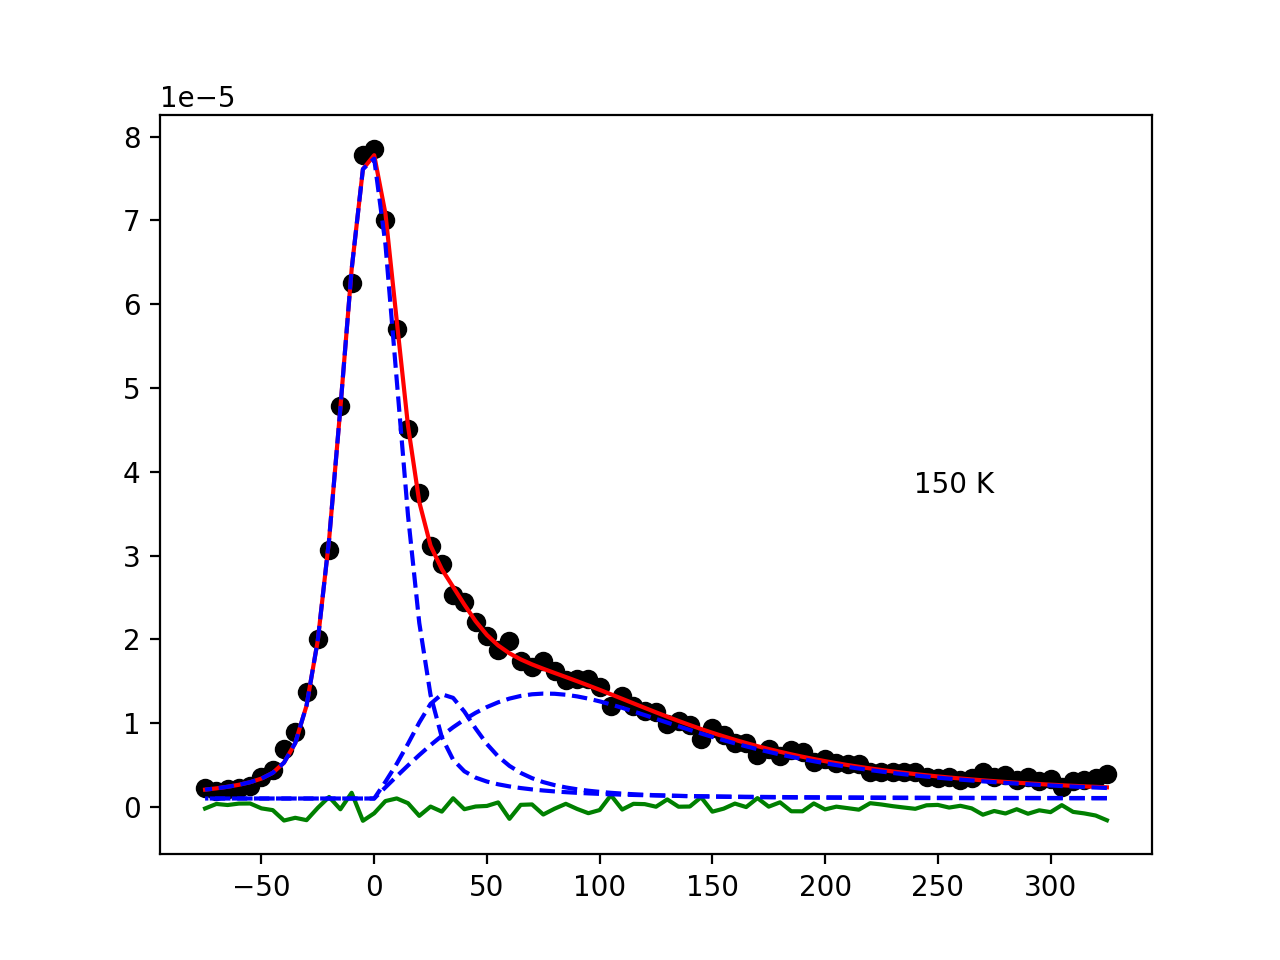

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 18683
    # data points      = 81
    # variables        = 10
    chi-square         = 4.3697e-11
    reduced chi-square = 6.1545e-13
    Akaike info crit   = -2268.10404
    Bayesian info crit = -2244.15955
[[Variables]]
    El_area:   0.00307272 +/- 5.6891e-05 (1.85%) (init = 0.002)
    El_wid:    31.6502546 +/- 0.51043912 (1.61%) (init = 30)
    El_pk:    -1.81222247 +/- 0.22178622 (12.24%) (init = 0)
    El_ratio:  0.5892655 (fixed)
    Pk1_area:  8.3210e-04 +/- 3.0733e-04 (36.93%) (init = 0.001)
    Pk1_pk:    30.3735754 +/- 1.93464594 (6.37%) (init = 30)
    Pk1_wid:   42.6414832 +/- 9.03349941 (21.18%) (init = 40)
    Pk2_area:  0.00606622 +/- 0.00364897 (60.15%) (init = 0.006)
    Pk2_pk:    56.8039184 +/- 26.9600404 (47.46%) (init = 73)
    Pk2_wid:   216.357347 +/- 25.9335724 (11.99%) (init = 170)
    bg:        1.0000e-06 +/- 7.0067e-08 (7.01%) (init = 1e-07)
[[Correlations]] (unreported correlation

<IPython.core.display.Javascript object>


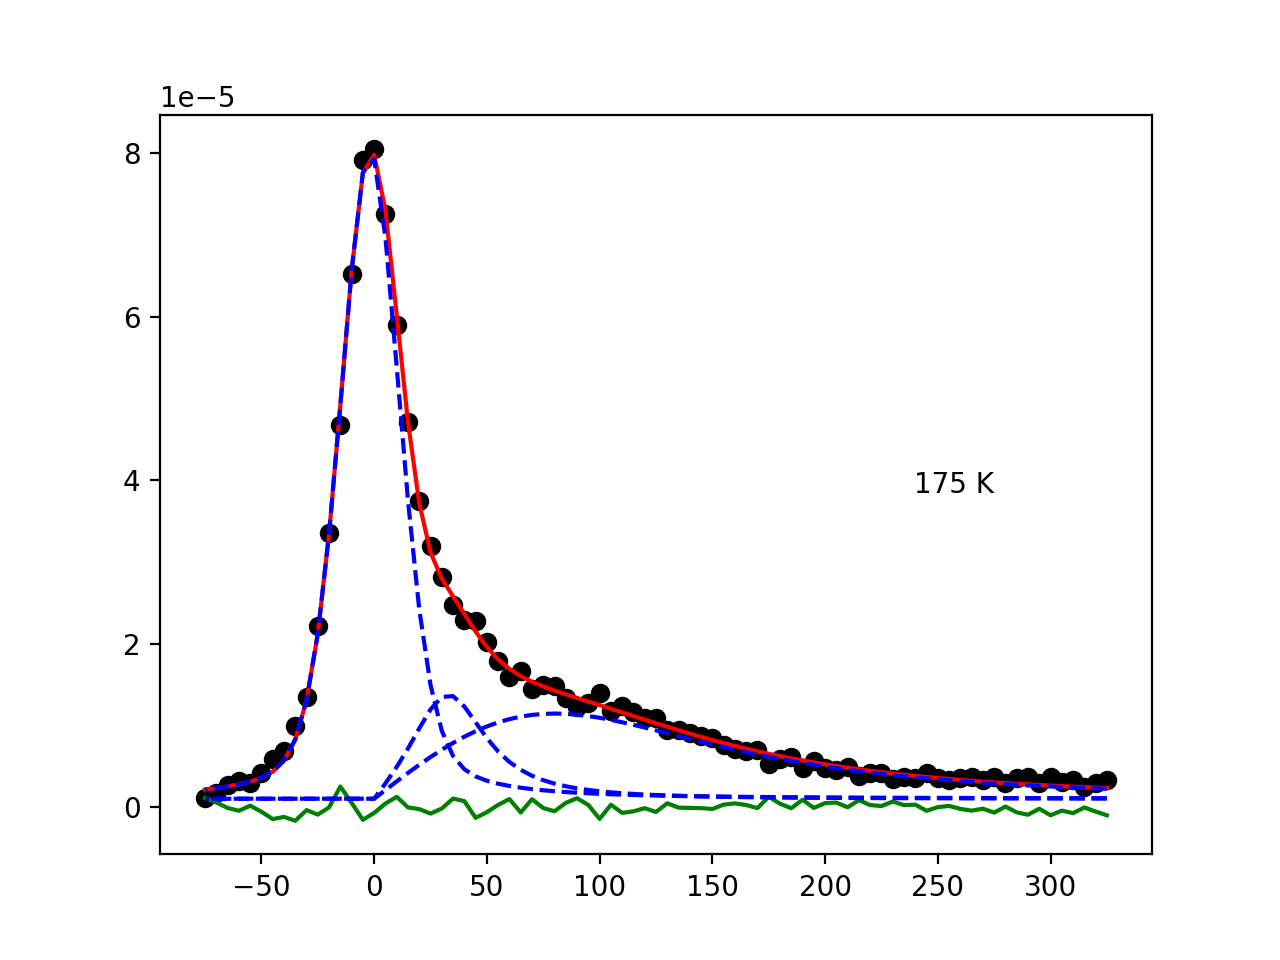

In [10]:
elpks = []
elpks_err = []
elpkwids = []
elpkwids_err = []
elpkAreas = []
elpkAreas_err = []

magpks_ALor = []
magpks_ALor_err = []
magpkwids_ALor = []
magpkwids_ALor_err = []
magpkAreas_ALor = []
magpkAreas_ALor_err = []

conpks_ALor = []
conpks_ALor_err = []
conpkwids_ALor = []
conpkwids_ALor_err = []
conpkAreas_ALor = []
conpkAreas_ALor_err = []

bg = []
bg_err = []
'''
a0 = params['El_ratio']
    A0 = params['El_area']
    w0 = params['El_wid']
    x0 = params['El_pk']

    A1 = params['Pk1_area']
    x1 = params['Pk1_pk']
    w1 = params['Pk1_wid']
    
    A2 = params['Pk2_area']
    x2 = params['Pk2_pk']
    w2 = params['Pk2_wid']
    
    bg = params['bg']
'''

for t, i in zip(T, np.arange(17)):
    final3, result3 = fit_Tdep3(warmingdata[3*i, :], warmingdata[3*i+1, :], t, plot_fit=True)
    
    elpks.append(result3.params['El_pk'].value)
    elpks_err.append(result3.params['El_pk'].stderr)
    
    elpkwids.append(result3.params['El_wid'].value)
    elpkwids_err.append(result3.params['El_wid'].stderr)
    
    elpkAreas.append(result3.params['El_area'].value)
    elpkAreas_err.append(result3.params['El_area'].stderr)
    
    
    magpks_ALor.append(result3.params['Pk1_pk'].value)
    magpks_ALor_err.append(result3.params['Pk1_pk'].stderr)
    
    magpkwids_ALor.append(result3.params['Pk1_wid'].value)
    magpkwids_ALor_err.append(result3.params['Pk1_wid'].stderr)
    
    magpkAreas_ALor.append(result3.params['Pk1_area'].value)
    magpkAreas_ALor_err.append(result3.params['Pk1_area'].stderr)

    
    conpks_ALor.append(result3.params['Pk2_pk'].value)
    conpks_ALor_err.append(result3.params['Pk2_pk'].stderr)
    
    conpkwids_ALor.append(result3.params['Pk2_wid'].value)
    conpkwids_ALor_err.append(result3.params['Pk2_wid'].stderr)
    
    conpkAreas_ALor.append(result3.params['Pk2_area'].value)
    conpkAreas_ALor_err.append(result3.params['Pk2_area'].stderr)

    bg.append(result3.params['bg'].value)
    bg_err.append(result3.params['bg'].stderr)
       
elpks = np.array(elpks)
elpks_err = np.array(elpks_err)
elpkwids_ALor = np.array(elpkwids) #delete ALor
elpkwids_ALor_err = np.array(elpkwids_err) #delete ALor
elpkAreas_ALor = np.array(elpkAreas) #delete ALor
elpkAreas_ALor_err = np.array(elpkAreas_err) #delete ALor

magpks_ALor = np.array(magpks_ALor)
magpks_ALor_err = np.array(magpks_ALor_err)
magpkwids_ALor = np.array(magpkwids_ALor)
magpkwids_ALor_err = np.array(magpkwids_ALor_err)
magpkAreas_ALor = np.array(magpkAreas_ALor)
magpkAreas_ALor_err = np.array(magpkAreas_ALor_err)

conpks_ALor = np.array(conpks_ALor)
conpks_ALor_err = np.array(conpks_ALor_err)
conpkwids_ALor = np.array(conpkwids_ALor)
conpkwids_ALor_err = np.array(conpkwids_ALor_err)
conpkAreas_ALor = np.array(conpkAreas_ALor)
conpkAreas_ALor_err = np.array(conpkAreas_ALor_err)

bg = np.array(bg)
bg_err = np.array(bg_err)

<IPython.core.display.Javascript object>


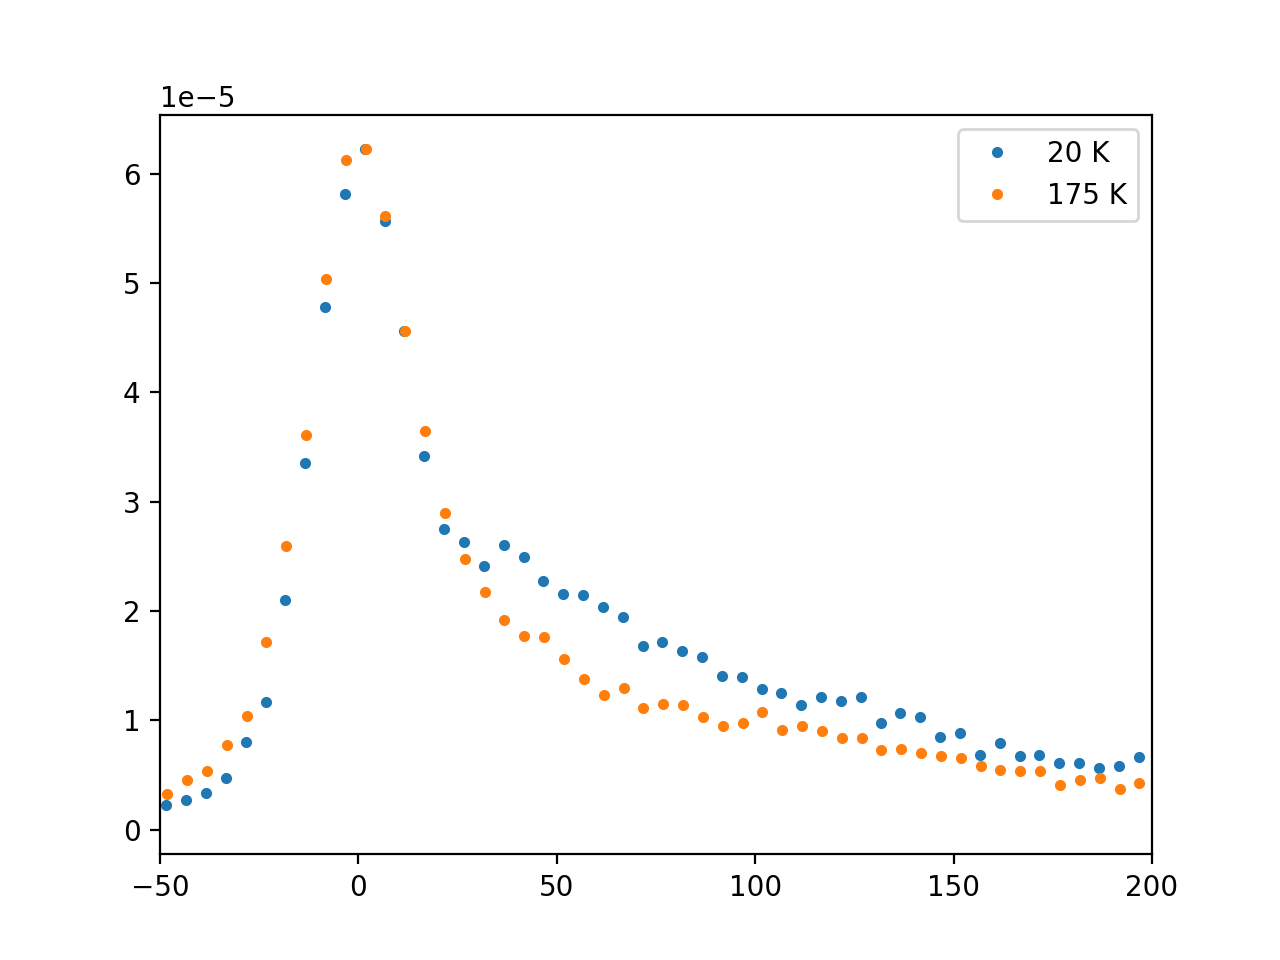

In [11]:
df_eladj = df.copy()
maxValues = df_eladj.max()
max_20 = maxValues['intensity_20']
plt.figure()
for t, i in zip(T, np.arange(17)):
    df_eladj["eloss_"+str(T[i])] = df_eladj["eloss_"+str(T[i])]-elpks[i]
    
    norm = maxValues['intensity_'+str(T[i])]/max_20
    
    df_eladj["intensity_"+str(T[i])] = df_eladj["intensity_"+str(T[i])]/norm
    emax = np.max(tempy)
    if i == 0 or i == 16:
        plt.plot(df_eladj["eloss_"+str(T[i])], df_eladj["intensity_"+str(T[i])], '.', label=str(T[i])+' K')
    
plt.xlim(-50, 200)
plt.legend()
plt.savefig('plots/RIXS_Tdep_stacked_normalized_extended.png')
    
plt.show()

In [12]:
df_allfits = pd.DataFrame()

In [13]:
for i in np.arange(17):
    warmingdata[3*i, :] = warmingdata[3*i, :] - elpks[i]

<IPython.core.display.Javascript object>


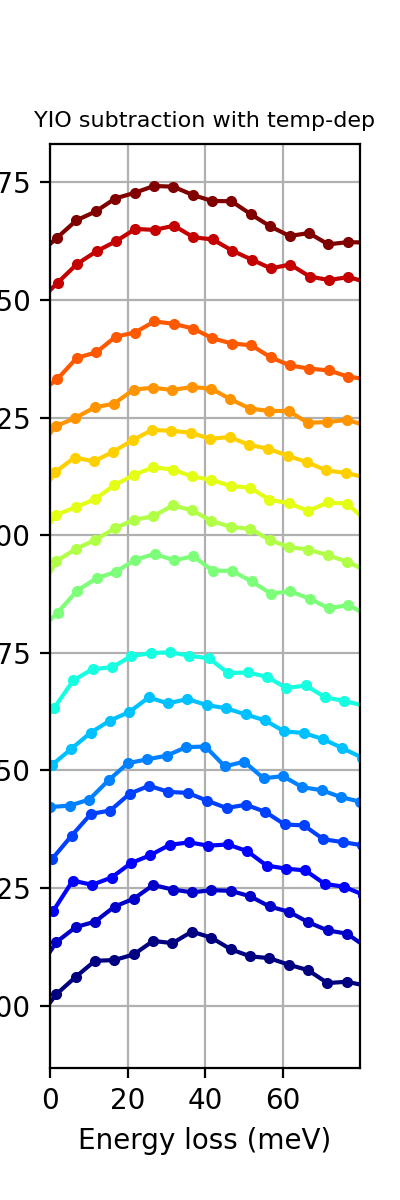

In [14]:
mag_sum = []

#T = [20, 40, 60, 90, 120, 80, 100, 105, 110, 115, 125, 130, 135, 140, 145, 150, 175]

df_sub = pd.DataFrame()

plt.figure(figsize=(2,6))
# plt.figure()
colors = plt.cm.jet(np.linspace(0, 1, 17))
for t, i in zip(T, np.arange(17)):
    if i == 7 or i == 14: #105 and 145
        continue
    sig0 = elpkwids_ALor[i]/(2*np.sqrt(2*np.log(2))) 
    Elas = 0.5892655*elpkAreas_ALor[i]*np.exp(-(warmingdata[3*i, :]-elpks[i])**2/2/sig0**2)/sig0/np.sqrt(2*np.pi)+(1-0.5892655)*elpkAreas_ALor[i]*(elpkwids_ALor[i]/2)/np.pi/((warmingdata[3*i, :]-elpks[i])**2+(elpkwids_ALor[i]/2)**2) #pseudoVoigt
    Magcon = np.mean(conpkAreas_ALor)*(np.mean(conpkwids_ALor)/2)/np.pi/((warmingdata[3*i, :]-(np.mean(conpks_ALor)-np.mean(elpks)))**2+(np.mean(conpkwids_ALor)/2)**2)-np.mean(conpkAreas_ALor)*(np.mean(conpkwids_ALor)/2)/np.pi/((warmingdata[3*i, :]+(np.mean(conpks_ALor)-np.mean(elpks)))**2+(np.mean(conpkwids_ALor)/2)**2) #continuum without bose factor
    aLor_Magcon = np.where(Magcon<0, 0., Magcon)
    tempy = warmingdata[3*i+1, :] - aLor_Magcon - Elas - bg[i]
    mag_sum.append(tempy[40:67].sum())
    
    plt.plot(warmingdata[3*i, :], tempy+i*1e-5, '.-', label=str(t)+' K', color=colors[i])
    #df = pd.DataFrame({"eloss" : warmingdata[0, :], "subtracted intensity" : tempy})
    #df.to_csv("YIO100nm_"+str(t)+"K_subtracted_intensity.csv", index=False)
    
    #if i == 0:
     #   df_sub["eloss"] = warmingdata[0, :]
        
    df_sub["eloss_"+str(T[i])] = warmingdata[3*i, :]
    df_sub["intensity_subtracted"+str(T[i])] = tempy

df_sub.to_csv("YIO100nm_all_Tdeps_subtracted_fixed.csv", index=False)

#     plt.plot(tempy+i*0.5e-5, '.-', label=str(t)+' K', color=colors[i])
# plt.legend()
mag_sum = np.array(mag_sum)
plt.grid('True')
plt.xlim(0, 80)
plt.xticks([0, 20, 40, 60])
plt.xlabel('Energy loss (meV)')
plt.ylabel('Intensity stacking')
plt.title('YIO subtraction with temp-dep', fontsize=8)
#plt.legend()
plt.savefig('plots/YIO100nm_Tdep_subtracted.png')
plt.show()